<a href="https://colab.research.google.com/github/sammitako/CS-GY-6513-Big-Data/blob/master/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!pip install rapidfuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

# Duplicate image URLs
We need an 'image' column to classify species, which is the image URL provided by the page's metadata.

- We found out that the image is not directly relevant to the product advertised.
- We discovered that even though the domains differ, the image URL is duplicated. I assume the advertisement is posted by a bot on multiple websites.

We will remove the duplicate image URLs; however, at this stage, we will not address the irrelevant images. We will assume that the image URL represents the "most relevant image.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Big Data/Team Notebook/data/final_cleaned_data.csv')
df.head()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd
0,adventures and bones color ebay hailstones hal...,adventures and bones color ebay hailstones hal...,adventures and bones color ebay hailstones hal...,adventures and at best bones color deals ebay ...,ebay.com.au,Australia,an animal body part,22.25,AUD,NaN,https://images.awesomebooks.com/images/books/r...,https://www.ebay.com.au/itm/384104329587?amdat...,NaN,au,Australia,34
1,contortus ebay hill miocene physogaleus shark ...,contortus ebay hill miocene physogaleus shark ...,contortus ebay hill miocene physogaleus shark ...,and at best contortus deals delivery ebay find...,ebay.co.uk,United Kingdom,an animal body part,12.63,GBP,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.co.uk/itm/222613331802,NaN,uk,United Kingdom,10
2,azaz contortus ebay hill physogaleus sharktooth,azaz contortus ebay hill physogaleus sharktooth,azaz contortus ebay hill physogaleus sharktooth,and at azaz best contortus deals ebay find for...,ebay.com,NaN,an animal body part,111.39,CNY,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.com/itm/222613331802?_ul=CN,NaN,com,NaN,790
3,contortus de dent ebay hill miocune physogaleu...,contortus de dent ebay hill miocune physogaleu...,contortus de dent ebay hill miocune physogaleu...,comparez contortus darticles de dent des docca...,ebay.fr,France,an animal body part,12.22,EUR,NaN,https://i.ebayimg.com/images/g/~M8AAOSwjuBZlzv...,https://www.ebay.fr/itm/222617333943?amdata=en...,NaN,fr,France,11
4,colline contortus de dent ebay miocune physoga...,colline contortus de dent ebay miocune physoga...,colline contortus de dent ebay miocune physoga...,colline comparez contortus darticles de dent d...,ebay.fr,France,an animal body part,14.53,EUR,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.fr/itm/222613331802,NaN,fr,France,13


In [ ]:
# We can confirm that we do have duplicate URLs in our data.
image_column_as_list = df['image'].tolist()
image_column_as_list[0:10]

['https://images.awesomebooks.com/images/books/rnaimages/9996402263_1.jpg',
 'https://i.ebayimg.com/images/g/x~gAAOSwtsVZkchE/s-l500.jpg',
 'https://i.ebayimg.com/images/g/x~gAAOSwtsVZkchE/s-l500.jpg',
 'https://i.ebayimg.com/images/g/~M8AAOSwjuBZlzvK/s-l500.jpg',
 'https://i.ebayimg.com/images/g/x~gAAOSwtsVZkchE/s-l500.jpg',
 'https://i.ebayimg.com/images/g/CQkAAOSwbtFlGxOL/s-l500.jpg',
 'https://i.ebayimg.com/images/g/CQkAAOSwbtFlGxOL/s-l500.jpg',
 'https://i.ebayimg.com/images/g/Q1IAAOSws29lGwlq/s-l500.jpg',
 'https://i.ebayimg.com/images/g/UukAAOSwlfJlGwl5/s-l500.jpg',
 'https://i.ebayimg.com/images/g/4IQAAOSwmHtlGwk5/s-l500.jpg']

In [ ]:
url_counts = df['image'].value_counts()

duplicates = url_counts[url_counts > 1]

# Count the number of duplicate URLs
num_duplicate_urls = duplicates.sum()

# Total count of rows that are duplicates, including all instances of duplication.
print(f"Number of duplicate image URLs: {num_duplicate_urls}")

Number of duplicate image URLs: 4638


In [ ]:
print(f"Number of unique image URLs that are duplicated: {len(duplicates)}")

Number of unique image URLs that are duplicated: 1662


In [ ]:
duplicate_urls = df.duplicated(subset='image', keep=False)

# The rows where duplication occurs, and if a URL appears more than twice, all of those rows are included in this count.
duplicate_rows = df[duplicate_urls]

# Display the duplicate rows
duplicate_rows

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd
1,contortus ebay hill miocene physogaleus shark ...,contortus ebay hill miocene physogaleus shark ...,contortus ebay hill miocene physogaleus shark ...,and at best contortus deals delivery ebay find...,ebay.co.uk,United Kingdom,an animal body part,12.63,GBP,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.co.uk/itm/222613331802,NaN,uk,United Kingdom,10
2,azaz contortus ebay hill physogaleus sharktooth,azaz contortus ebay hill physogaleus sharktooth,azaz contortus ebay hill physogaleus sharktooth,and at azaz best contortus deals ebay find for...,ebay.com,NaN,an animal body part,111.39,CNY,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.com/itm/222613331802?_ul=CN,NaN,com,NaN,790
4,colline contortus de dent ebay miocune physoga...,colline contortus de dent ebay miocune physoga...,colline contortus de dent ebay miocune physoga...,colline comparez contortus darticles de dent d...,ebay.fr,France,an animal body part,14.53,EUR,NaN,https://i.ebayimg.com/images/g/x~gAAOSwtsVZkch...,https://www.ebay.fr/itm/222613331802,NaN,fr,France,13
5,almofada brinquedo d de ebay estereo gato peca...,almofada brinquedo d de ebay estereo gato peca...,almofada brinquedo d de ebay estereo gato peca...,almofada and at best brinquedo d de deals ebay...,ebay.com,NaN,an animal body part,74.43,EUR,NaN,https://i.ebayimg.com/images/g/CQkAAOSwbtFlGxO...,https://www.ebay.com/itm/155807567987?_ul=PT,NaN,com,NaN,68
6,cuscino d ebay gatto giocattolo imbottito pelu...,cuscino d ebay gatto giocattolo imbottito pelu...,cuscino d ebay gatto giocattolo imbottito pelu...,articoli caratteristiche con confronta consegn...,ebay.it,Italy,an animal body part,74.43,EUR,NaN,https://i.ebayimg.com/images/g/CQkAAOSwbtFlGxO...,https://www.ebay.it/itm/155807567987?amdata=en...,NaN,it,Italy,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17423,bl caiman ebay latirostris mnh ss yacare,bl caiman ebay latirostris mnh ss yacare,bl caiman ebay latirostris mnh ss yacare,and at best bl caiman deals ebay find for free...,ebay.com,NaN,an animal body part,138.49,CNY,NaN,https://i.ebayimg.com/images/g/5h8AAOSwTUVk0hT...,https://www.ebay.com/itm/126105039342?_ul=CN,NaN,com,NaN,982
17424,crocodylus ebay mnh niloticus novaeguineae ss,crocodylus ebay mnh niloticus novaeguineae ss,crocodylus ebay mnh niloticus novaeguineae ss,and at best crocodylus deals ebay find for fre...,ebay.com,NaN,an animal body part,131.62,CNY,NaN,https://i.ebayimg.com/images/g/fzcAAOSwFJlk0g9...,https://www.ebay.com/itm/125590485442?_ul=CN,NaN,com,NaN,933
17425,crocodylus ebay niloticus porosus ss,crocodylus ebay niloticus porosus ss,crocodylus ebay niloticus porosus ss,and at best crocodylus deals ebay find for fre...,ebay.com,NaN,an animal body part,119.49,CNY,NaN,https://i.ebayimg.com/images/g/YsUAAOSwt45lEwP...,https://www.ebay.com/itm/126111169118?_ul=CN,NaN,com,NaN,847
17426,canis ebay estampillada hoja iic lupus montada...,canis ebay estampillada hoja iic lupus montada...,canis ebay estampillada hoja iic lupus montada...,and at best canis deals ebay estampillada find...,ebay.com,NaN,an animal body part,5.00,USD,NaN,https://i.ebayimg.com/images/g/DowAAOSwhKpj43p...,https://www.ebay.com/itm/115699607920?_ul=PA,NaN,com,NaN,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17433 entries, 0 to 17432
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  17433 non-null  object 
 1   title                 17433 non-null  object 
 2   product               17433 non-null  object 
 3   description           17432 non-null  object 
 4   domain                17433 non-null  object 
 5   country               14209 non-null  object 
 6   label_product         17433 non-null  object 
 7   price                 17433 non-null  float64
 8   currency              17433 non-null  object 
 9   production_date       14 non-null     object 
 10  image                 17412 non-null  object 
 11  url                   17433 non-null  object 
 12  location              4744 non-null   object 
 13  domain_country_code   17433 non-null  object 
 14  domain_country        9544 non-null   object 
 15  normalized_price_us

We will eliminate duplicates based on the 'image' field, retaining the first occurrence associated with **the longest text**. This approach is grounded in the assumption that longer text yields more information for species identification. \\

To implement this, we will assess text length in the following order: description, product, title, and name.

In [ ]:
df = df.sort_values(by=['description', 'product', 'title', 'name'],
                    key=lambda col: col.str.len(),
                    ascending=False)

df = df.drop_duplicates(subset='image', keep='first')

In [ ]:
file_path = '/content/drive/MyDrive/Big Data/Team Notebook/data/url_cleaned_data.csv'
df.to_csv(file_path, index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14437 entries, 8201 to 2707
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14437 non-null  object 
 1   title                 14437 non-null  object 
 2   product               14437 non-null  object 
 3   description           14436 non-null  object 
 4   domain                14437 non-null  object 
 5   country               12249 non-null  object 
 6   label_product         14437 non-null  object 
 7   price                 14437 non-null  float64
 8   currency              14437 non-null  object 
 9   production_date       14 non-null     object 
 10  image                 14436 non-null  object 
 11  url                   14437 non-null  object 
 12  location              4738 non-null   object 
 13  domain_country_code   14437 non-null  object 
 14  domain_country        7590 non-null   object 
 15  normalized_price_

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Big Data/Team Notebook/data/url_cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14437 entries, 0 to 14436
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14437 non-null  object 
 1   title                 14437 non-null  object 
 2   product               14437 non-null  object 
 3   description           14436 non-null  object 
 4   domain                14437 non-null  object 
 5   country               12249 non-null  object 
 6   label_product         14437 non-null  object 
 7   price                 14437 non-null  float64
 8   currency              14437 non-null  object 
 9   production_date       14 non-null     object 
 10  image                 14436 non-null  object 
 11  url                   14437 non-null  object 
 12  location              4738 non-null   object 
 13  domain_country_code   14437 non-null  object 
 14  domain_country        7590 non-null   object 
 15  normalized_price_us

# Download images
A list of expected predictions:
1. Shark, Object (post card, badge)
2. Beetle
3. Beetle
4. Beetle
5. Beetle
6. Shark, Object (post card, badge)
7. Beetle
8. Wood, Object, Wolf
9. Rhinoceros, Rhino, Object (badge)
10. Wolf, Object (badge)


In [8]:
image_column_as_list = df['image'].tolist()
image_column_as_list[0:10]

['https://www.picclickimg.com/ne0AAOSwn4lim49Q/JAWS-Great-White-Shark-Silver-Coin-Steven.webp',
 'https://www.picclickimg.com/7rEAAOSwAoNk6CFY/Carabidae-Cychrini-Scaphinotus-Steniridia-ridingsii-monongahelae-USA.webp',
 'https://www.picclickimg.com/uTYAAOSwhElk6CMq/Carabidae-Carabinae-Cychrini-Scaphinotus-Steniridia-andrewsii-germari-USA.webp',
 'https://www.picclickimg.com/m6IAAOSwZNJk6B~b/Carabidae-Scaphinotus-Irichroa-viduus-RARE-golden-green-form-USA.webp',
 'https://www.picclickimg.com/a5QAAOSwVGhiq~Ln/Carabidae-Carabinae-Calosoma-s-lato-Calosoma-Calosoma-sycophantha.webp',
 'https://www.picclickimg.com/qk4AAOSwFHJim5AB/JAWS-Great-White-Shark-Silver-Coin-Spielberg-Roy.webp',
 'https://www.picclickimg.com/C48AAOSw5bBiKB9l/Carabidae-Carabinae-Carabus-Carabus-Carabus-goryi-USA.webp',
 'https://www.picclickimg.com/ybUAAOSwp5JWVoj0/Antoninus-Pius-138AD-Ephesus-in-Ionia-CALYDONIAN-Boar.webp',
 'https://www.picclickimg.com/htYAAOSwHxdkjFcl/Rhino-Wild-Animal-Zoo-Embroidered.webp',
 'https

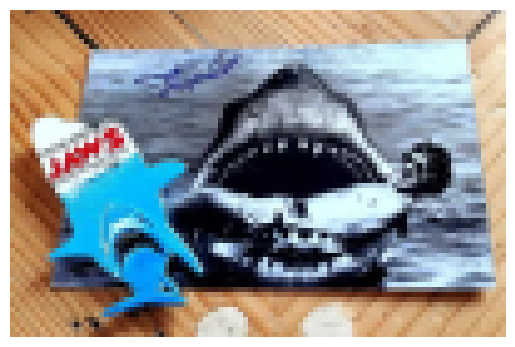

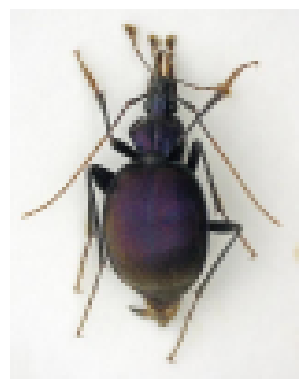

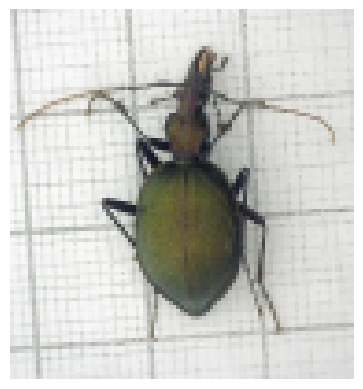

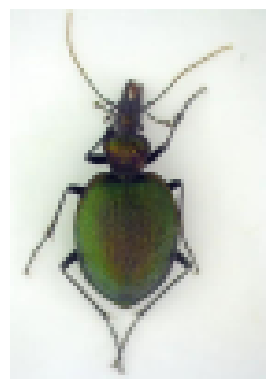

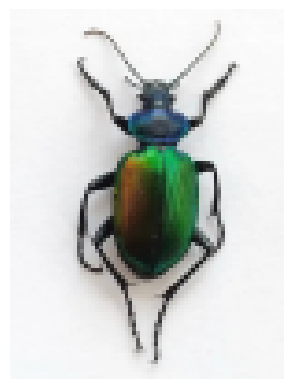

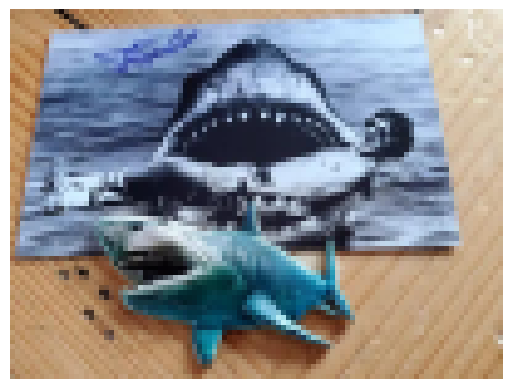

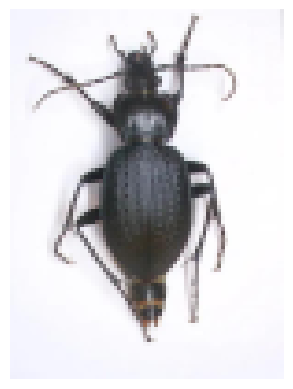

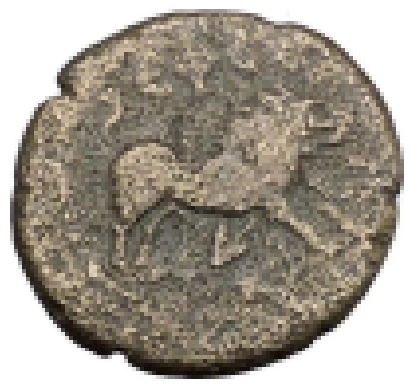

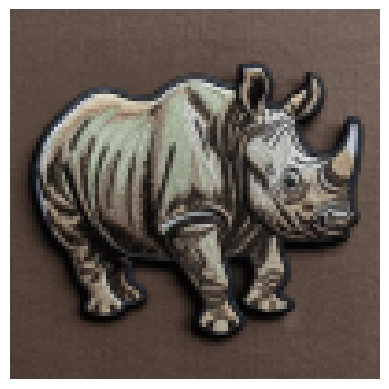

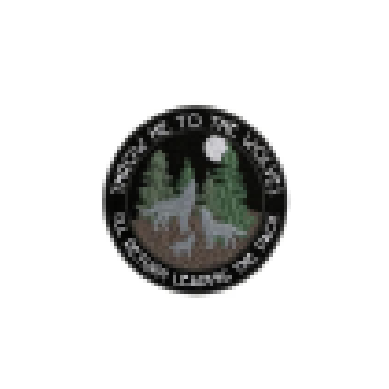

In [ ]:
import cv2 as cv
from matplotlib import pyplot as plt

def display_image(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def resize_with_aspect_ratio(image, size=100):
    h, w = image.shape[:2]
    if h > w:
        r = size / float(h)
        dim = (int(w * r), size)
    else:
        r = size / float(w)
        dim = (size, int(h * r))
    return cv.resize(image, dim, interpolation=cv.INTER_AREA)

for i in range(10):
    img_path = f'/content/drive/MyDrive/Big Data/Project/Data/image_{i}.jpg'

    img = cv.imread(img_path)
    if img is not None:
        resized_img = resize_with_aspect_ratio(img)
        display_image(resized_img)
    else:
        print(f"Image at {img_path} could not be loaded.")

In [10]:
# Download WEBP image files from URLs and convert them to JPG format
import requests
from PIL import Image
from io import BytesIO

def download_and_convert_image(url, save_path):
  try:
    response = requests.get(url, verify=False)  # Skipping SSL verification
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content)).convert("RGB")
        image.save(save_path, "JPEG")
        return True
  except Exception as e:
    print(f"An error occurred while downloading {url}: {e}")
    return False

In [15]:
%%time
import os
import warnings
from urllib3.exceptions import InsecureRequestWarning

# Suppress only the InsecureRequestWarning from urllib3
warnings.simplefilter('ignore', InsecureRequestWarning)

image_directory = '/content/drive/MyDrive/Big Data/Project/Data/'

# Clear existing images in the directory if starting anew
for filename in os.listdir(image_directory):
    if filename.endswith('.jpg'):
        os.remove(os.path.join(image_directory, filename))

image_column_as_list = df['image'].tolist()
df['image_path'] = pd.NA

for i in range(len(image_column_as_list)):
    url = image_column_as_list[i]

    try:
      # Check if the URL is valid
      if pd.notna(url) and url.startswith('http'):
        image_path = f'{image_directory}image_{i}.jpg'
        success = download_and_convert_image(url, image_path)
        if success:
            df.at[i, 'image_path'] = image_path
        else:
            df.at[i, 'image_path'] = 'error'
      else:
          print(f"Invalid URL at index {i}: {url}")
          df.at[i, 'image_path'] = 'invalid_url'
    except requests.exceptions.SSLError as e:
      print(f"SSL Error for URL {url}: {e}")
    except Exception as e:
      print(f"Error for URL {url}: {e}")

df.to_csv('/content/drive/MyDrive/Big Data/Project/image_path.csv', index=False)
df.info()

Invalid URL at index 3898: nan


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


An error occurred while downloading https://d1o0zx25fn5p70.cloudfront.net/UlFHwjchpBjkzcpggXUC-deDGjU=/fit-in/500x0/rebuy-akeneo/products/default/main.svg: cannot identify image file <_io.BytesIO object at 0x7bf7a5c89ad0>
An error occurred while downloading https://tmpg.ecrater.com/stores/563276/651a83c0a15e6_563276b.jpg: HTTPSConnectionPool(host='tmpg.ecrater.com', port=443): Max retries exceeded with url: /stores/563276/651a83c0a15e6_563276b.jpg (Caused by SSLError(SSLError(1, '[SSL: DH_KEY_TOO_SMALL] dh key too small (_ssl.c:1007)')))
An error occurred while downloading https://tmpp.ecrater.com/stores/592650/651af13ca98bc_592650b.jpg: HTTPSConnectionPool(host='tmpp.ecrater.com', port=443): Max retries exceeded with url: /stores/592650/651af13ca98bc_592650b.jpg (Caused by SSLError(SSLError(1, '[SSL: DH_KEY_TOO_SMALL] dh key too small (_ssl.c:1007)')))
An error occurred while downloading https://tmpg.ecrater.com/stores/429064/651a79b523b08_429064b.jpg: HTTPSConnectionPool(host='tmpg.e

In [25]:
# A list of URLs that should be skipped during the downloading process due to the errors we've encountered
skip_urls = [
    'https://d1o0zx25fn5p70.cloudfront.net/UlFHwjchpBjkzcpggXUC-deDGjU=/fit-in/500x0/rebuy-akeneo/products/default/main.svg',
    'https://tmpg.ecrater.com/stores/563276/651a83c0a15e6_563276b.jpg',
    'https://tmpp.ecrater.com/stores/592650/651af13ca98bc_592650b.jpg',
    'https://tmpg.ecrater.com/stores/429064/651a79b523b08_429064b.jpg',
    'https://tmpg.ecrater.com/stores/531419/65199f903842a_531419b.jpg',
    'https://tmpg.ecrater.com/stores/583312/651a92d84cf84_583312b.jpg',
    'https://tmpg.ecrater.com/stores/612722/65198ddd63883_612722b.jpg',
    'https://tmpp.ecrater.com/stores/592650/651aff529abd9_592650b.jpg',
    'https://tmpp.ecrater.com/stores/404163/6518fdbb26197_404163b.jpg',
    'https://tmpg.ecrater.com/stores/575426/65196829ddaee_575426b.jpg'
]

We need to identify the specific images that failed to download and attempt to download only those images again, without re-downloading the images that were downloaded successfully.

In [ ]:
%%time
image_directory = '/content/drive/MyDrive/Big Data/Project/Data/'
image_column_as_list = df['image'].tolist()
df['image_path'] = pd.NA

# Create a set of already downloaded image filenames
downloaded_images = set(os.listdir(image_directory))

# for i, url in enumerate(df['image'][:10]):
for i, url in enumerate(image_column_as_list):
    image_path = f'{image_directory}image_{i}.jpg'

    if url in skip_urls:
        print(f"Skipping download for URL at index {i}: {url}")
        df.at[i, 'image_path'] = 'skipped'
    elif os.path.basename(image_path) in downloaded_images:
        print(f"Image already downloaded at index {i}: {url}")
        df.at[i, 'image_path'] = image_path
    else:
        if pd.notna(url) and url.startswith('http'):
            success = download_and_convert_image(url, image_path)
            if success:
                df.at[i, 'image_path'] = image_path
            else:
                df.at[i, 'image_path'] = 'error'
        else:
            print(f"Invalid URL at index {i}: {url}")
            df.at[i, 'image_path'] = 'invalid_url'

df.to_csv('/content/drive/MyDrive/Big Data/Project/image_path.csv', index=False)

In [32]:
df = pd.read_csv('/content/drive/MyDrive/Big Data/Project/image_path.csv')
df.tail()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,image_path
14432,bag black braided cobra implora skin tassel,bags christmas cobra free genuine natural ship...,bags christmas cobra free genuine natural ship...,size,implora.com,NaN,an animal body part,325.00,USD,NaN,http://implora.com/images/0773-1.jpg,http://implora.com/product.asp?jd=Implora%20Bl...,NaN,com,NaN,325,/content/drive/MyDrive/Big Data/Project/Data/i...
14433,from mussel polished thailand,from mussel polished thailand,from mussel polished thailand,each,boneroom.com,NaN,an animal body part,5.00,USD,NaN,http://www.boneroom.com/uploads/4/8/1/1/481182...,http://www.boneroom.com/store/p4584/Polished_m...,NaN,com,NaN,5,/content/drive/MyDrive/Big Data/Project/Data/i...
14434,black implora ostrich skin xin,black christmas free genuine hides leather lea...,black christmas free genuine hides leather lea...,h,implora.com,NaN,an animal body part,480.00,USD,NaN,http://implora.com/images/0503_02-1.jpg,http://implora.com/product.asp?jd=Implora%20Os...,NaN,com,NaN,480,/content/drive/MyDrive/Big Data/Project/Data/i...
14435,in lucite octopus,in lucite octopus,in lucite octopus,x,boneroom.com,NaN,an animal body part,25.00,USD,NaN,http://www.boneroom.com/uploads/4/8/1/1/481182...,http://www.boneroom.com/store/p3874/Octopus_in...,NaN,com,NaN,25,/content/drive/MyDrive/Big Data/Project/Data/i...
14436,accurate description great seller,black collaboration hoodie mastermind shark sk...,black collaboration hoodie mastermind shark sk...,NaN,ioffer.com,NaN,an animal body part,24.99,USD,NaN,http://www.ioffer.com/rails/active_storage/blo...,http://www.ioffer.com/vp/mastermind-x-collabor...,NaN,com,NaN,25,/content/drive/MyDrive/Big Data/Project/Data/i...


I can confirm that the images that failed to download display a "404 Not Found" page, and the image file names correspond to the row index.

In [39]:
# View the specific rows where 'image_path' columns is equal to 'error' or 'invalid_url'
error_df = df[(df['image_path'] == 'error') | (df['image_path'] == 'invalid_url')]

error_df['image']

411      http://www.raydworkshop.com/es-got/img/gots/go...
412      http://www.raydworkshop.com/es-got/img/gots/go...
2409     https://da1urhpfd469z.cloudfront.net/uploads/a...
2557     https://da1urhpfd469z.cloudfront.net/uploads/a...
2686     https://da1urhpfd469z.cloudfront.net/uploads/a...
                               ...                        
14389    https://www.thetaxidermystore.com/media/catalo...
14390    https://www.thetaxidermystore.com/media/catalo...
14393    https://www.thetaxidermystore.com/media/catalo...
14394    https://www.thetaxidermystore.com/media/catalo...
14400    https://www.thetaxidermystore.com/media/catalo...
Name: image, Length: 93, dtype: object

In [49]:
specific_url_df = df[df['image_path'] == '/content/drive/MyDrive/Big Data/Project/Data/image_413.jpg']

specific_url_df

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,image_path
413,bauers bonefishpermit by crab flats fly free n...,bauers bonefishpermit by crab flats fly free n...,bauers bonefishpermit by crab flats fly free n...,a accept acceptable add additional after align...,picclick.com,United States,an animal body part,8.5,USD,NaN,https://www.picclickimg.com/1RMAAOSwsrBeuzV7/B...,http://picclick.com/Bauers-Flats-Crab-Bonefish...,"Boca Raton, Florida, US",com,NaN,8,/content/drive/MyDrive/Big Data/Project/Data/i...


In [50]:
specific_url_df = df[df['image_path'] == '/content/drive/MyDrive/Big Data/Project/Data/image_412.jpg']
specific_url_df

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,image_path


In [31]:
# Check the number of downloaded image files
import os

image_directory = '/content/drive/MyDrive/Big Data/Project/Data/'

all_files = os.listdir(image_directory)
jpg_files_count = sum(file.endswith('.jpg') for file in all_files)
print(f"Number of .jpg image files in the directory: {jpg_files_count}")

Number of .jpg image files in the directory: 14334


# Keras Applications
Reference: https://keras.io/api/applications/

In [61]:
df = pd.read_csv('/content/drive/MyDrive/Big Data/Project/image_path.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14437 entries, 0 to 14436
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14437 non-null  object 
 1   title                 14437 non-null  object 
 2   product               14437 non-null  object 
 3   description           14436 non-null  object 
 4   domain                14437 non-null  object 
 5   country               12249 non-null  object 
 6   label_product         14437 non-null  object 
 7   price                 14437 non-null  float64
 8   currency              14437 non-null  object 
 9   production_date       14 non-null     object 
 10  image                 14436 non-null  object 
 11  url                   14437 non-null  object 
 12  location              4738 non-null   object 
 13  domain_country_code   14437 non-null  object 
 14  domain_country        7590 non-null   object 
 15  normalized_price_us

## ResNet50

Understanding ResNet is essential for appreciating the advancements in computer vision. The ResNet architecture, a significant leap forward in this field, was first introduced by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in their landmark 2015 research paper on computer vision, titled ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385?context=cs). This innovative neural network model enables the creation of exceptionally deep networks, exceeding 150 layers in some configurations, though ResNet50, a popular variant, is specifically designed with 50 layers.

Before the development of ResNet, it was theoretically believed that adding more layers to a neural network would reduce loss and increase accuracy. However, in practice, this led to a decrease in accuracy due to the "Vanishing Gradient Problem" encountered in Convolutional Neural Networks during backpropagation. ResNet addresses this problem through the implementation of Skip Connections, which involve adding the original input to the output of the convolutional block, thereby preserving the gradient flow through the network.

In [54]:
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [55]:
model = ResNet50(weights='imagenet')

predictions = []

# Loop through the first 10 images
for i in range(10):
    img_path = f'/content/drive/MyDrive/Big Data/Project/Data/image_{i}.jpg'

    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    decoded_preds = decode_predictions(preds, top=3)[0]

    keywords = [pred[1] for pred in decoded_preds]
    predictions.append(', '.join(keywords))

df.loc[0:9, 'ResNet50'] = predictions

# Keep only the first 10 rows
df = df.iloc[0:10]

1/1 [==============================] - 0s 336ms/step


In [56]:
df['ResNet50'].iloc[0:10]

0                             mask, pug, corkscrew
1              ground_beetle, tiger_beetle, weevil
2              ground_beetle, weevil, tiger_beetle
3         tiger_beetle, ground_beetle, leaf_beetle
4         ground_beetle, tiger_beetle, leaf_beetle
5             jigsaw_puzzle, book_jacket, envelope
6         ground_beetle, dung_beetle, tiger_beetle
7               buckle, chambered_nautilus, shield
8                        pitcher, hook, hair_slide
9    magnetic_compass, combination_lock, barometer
Name: ResNet50, dtype: object

In [62]:
# Now let's apply this to all the rows
# But this time, I will extract only the top one
# NO BATCH - 1h 26min 53s

%%time

model = ResNet50(weights='imagenet')

df['ResNet50'] = np.nan

# Loop through all the images
for i in range(len(df)):
    try:
        img_path = f'/content/drive/MyDrive/Big Data/Project/Data/image_{i}.jpg'

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Predict and decode the results
        preds = model.predict(x)
        decoded_preds = decode_predictions(preds, top=1)[0]  # Top 1 prediction
        top_pred = decoded_preds[0][1]
        df.at[i, 'ResNet50'] = top_pred

    except Exception as e:
        print(f"Error processing image at index {i}: {e}")
        continue
df.to_csv('/content/drive/MyDrive/Big Data/Project/resnet_50.csv', index=False)
df.info()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 186ms/step
Error processing image at index 9577: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_9577.jpg'
1/1 [==============================] - 0s 296ms/step
Error processing image at index 10453: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_10453.jpg'
1/1 [==============================] - 0s 189ms/step
Error processing image at index 10783: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_10783.jpg'
1/1 [==============================] - 0s 184ms/step
Error processing image at index 10813: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_10813.jpg'
1/1 [==============================] - 0s 189ms/step
Error processing image at index 10819: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_10

In [63]:
df.tail()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,image_path,ResNet50
14432,bag black braided cobra implora skin tassel,bags christmas cobra free genuine natural ship...,bags christmas cobra free genuine natural ship...,size,implora.com,NaN,an animal body part,325.00,USD,NaN,http://implora.com/images/0773-1.jpg,http://implora.com/product.asp?jd=Implora%20Bl...,NaN,com,NaN,325,/content/drive/MyDrive/Big Data/Project/Data/i...,mailbag
14433,from mussel polished thailand,from mussel polished thailand,from mussel polished thailand,each,boneroom.com,NaN,an animal body part,5.00,USD,NaN,http://www.boneroom.com/uploads/4/8/1/1/481182...,http://www.boneroom.com/store/p4584/Polished_m...,NaN,com,NaN,5,/content/drive/MyDrive/Big Data/Project/Data/i...,slug
14434,black implora ostrich skin xin,black christmas free genuine hides leather lea...,black christmas free genuine hides leather lea...,h,implora.com,NaN,an animal body part,480.00,USD,NaN,http://implora.com/images/0503_02-1.jpg,http://implora.com/product.asp?jd=Implora%20Os...,NaN,com,NaN,480,/content/drive/MyDrive/Big Data/Project/Data/i...,bulletproof_vest
14435,in lucite octopus,in lucite octopus,in lucite octopus,x,boneroom.com,NaN,an animal body part,25.00,USD,NaN,http://www.boneroom.com/uploads/4/8/1/1/481182...,http://www.boneroom.com/store/p3874/Octopus_in...,NaN,com,NaN,25,/content/drive/MyDrive/Big Data/Project/Data/i...,binder
14436,accurate description great seller,black collaboration hoodie mastermind shark sk...,black collaboration hoodie mastermind shark sk...,NaN,ioffer.com,NaN,an animal body part,24.99,USD,NaN,http://www.ioffer.com/rails/active_storage/blo...,http://www.ioffer.com/vp/mastermind-x-collabor...,NaN,com,NaN,25,/content/drive/MyDrive/Big Data/Project/Data/i...,suit


## VGG16
VGG16 is a deep convolutional network for image recognition developed by Karen Simonyan and Andrew Zisserman of the University of Oxford in a paper titled [“Very Deep Convolutional Networks for Large-Scale Image Recognition”](https://arxiv.org/pdf/1409.1556.pdf) in 2014. The model achieves its high level of accuracy by employing a series of convolutional layers with small receptive fields (3x3 filters), followed by max-pooling layers. One of the key contributions of the VGG16 model is its simplicity, using this uniform architecture to reach a depth of 16 layers (13 convolutional and 3 fully connected layers).

The VGG16 model was a runner-up in the 2014 ImageNet competition, but it became popular due to its simplicity and its capability to generalize. It can be used for a wide range of image recognition tasks and is particularly effective for capturing spatial hierarchies in images, which is crucial for identifying features in wildlife images. However, the VGG16 architecture is quite large in terms of the number of parameters, which can make it computationally intensive, especially in terms of memory usage.

In [31]:
df = pd.read_csv('/content/drive/MyDrive/Big Data/Project/resnet_50.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14437 entries, 0 to 14436
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14437 non-null  object 
 1   title                 14437 non-null  object 
 2   product               14437 non-null  object 
 3   description           14436 non-null  object 
 4   domain                14437 non-null  object 
 5   country               12249 non-null  object 
 6   label_product         14437 non-null  object 
 7   price                 14437 non-null  float64
 8   currency              14437 non-null  object 
 9   production_date       14 non-null     object 
 10  image                 14436 non-null  object 
 11  url                   14437 non-null  object 
 12  location              4738 non-null   object 
 13  domain_country_code   14437 non-null  object 
 14  domain_country        7590 non-null   object 
 15  normalized_price_us

In [66]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image

model = VGG16(weights='imagenet')

predictions = []

# Loop through the first 10 images
for i in range(10):
    img_path = f'/content/drive/MyDrive/Big Data/Project/Data/image_{i}.jpg'

    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    decoded_preds = decode_predictions(preds, top=3)[0]

    keywords = [pred[1] for pred in decoded_preds]
    predictions.append(', '.join(keywords))

df.loc[0:9, 'VGG16'] = predictions
df = df.iloc[0:10]

1/1 [==============================] - 1s 526ms/step


In [68]:
df['VGG16'].iloc[0:10]

0            birdhouse, envelope, jigsaw_puzzle
1            ground_beetle, dung_beetle, weevil
2     ground_beetle, weevil, long-horned_beetle
3      ground_beetle, tiger_beetle, leaf_beetle
4       ground_beetle, dung_beetle, leaf_beetle
5              coho, leatherback_turtle, packet
6       ground_beetle, dung_beetle, leaf_beetle
7                         shield, buckle, screw
8                buckle, tiger_cat, cowboy_boot
9    magnetic_compass, wall_clock, analog_clock
Name: VGG16, dtype: object

In [32]:
# BATCH & GPU: 1h 24min 42s
# RUNNING AGAIN: 2min 40s
%%time

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image

# Load the VGG16 model
model = VGG16(weights='imagenet')

def predict_batch(paths, model):
    imgs_array = []
    for img_path in paths:
        try:
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            imgs_array.append(x)
        except Exception as e:
            print(f"Error processing image at path {img_path}: {e}")
            continue
    if len(imgs_array) == 0:  # Check if all images in the batch failed
        return [np.nan] * len(paths)
    imgs_array = np.array(imgs_array)
    imgs_array = preprocess_input(imgs_array)

    try:
        preds = model.predict(imgs_array)
        decoded = decode_predictions(preds, top=1)
        top_preds = [pred[0][1] if len(pred) > 0 else np.nan for pred in decoded]
        return top_preds
    except Exception as e:
        print(f"Error during prediction: {e}")
        return [np.nan] * len(paths)

# Batch processing
batch_size = 32
df['VGG16'] = np.nan

for i in range(0, len(df), batch_size):
    batch_paths = [f'/content/drive/MyDrive/Big Data/Project/Data/image_{j}.jpg' for j in range(i, min(i + batch_size, len(df)))]
    batch_preds = predict_batch(batch_paths, model)
    df.loc[i:i+len(batch_preds)-1, 'VGG16'] = batch_preds

df.to_csv('/content/drive/MyDrive/Big Data/Project/vgg16.csv', index=False)
df.info()

1/1 [==============================] - 0s 33ms/step
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_411.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_411.jpg'
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_412.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_412.jpg'
1/1 [==============================] - 0s 37ms/step
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_2409.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_2409.jpg'
1/1 [==============================] - 0s 42ms/step
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_2557.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_2557.jpg'
1/1 [==============================] - 0s 40ms/step
Error processing image at path /

In [33]:
df.head()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,image_path,ResNet50,VGG16
0,book coin great jaws roy scheider shark signed...,book coin great jaws picclick roy scheider sha...,book coin great jaws picclick roy scheider sha...,a aaron abela ability able aboard about above ...,picclick.com,United Kingdom,an animal body part,15.74,USD,NaN,https://www.picclickimg.com/ne0AAOSwn4lim49Q/J...,http://picclick.com/JAWS-Great-White-Shark-Sil...,"Manchester, Take a look at my other items, GB",com,NaN,16,/content/drive/MyDrive/Big Data/Project/Data/i...,mask,birdhouse
1,carabidae cychrini monongahelae ridingsii scap...,carabidae cychrini monongahelae picclick ridin...,carabidae cychrini monongahelae picclick ridin...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,https://www.picclickimg.com/7rEAAOSwAoNk6CFY/C...,http://picclick.com/Carabidae-Cychrini-Scaphin...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle
2,andrewsii carabidae carabinae cychrini germari...,andrewsii carabidae carabinae cychrini germari...,andrewsii carabidae carabinae cychrini germari...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,https://www.picclickimg.com/uTYAAOSwhElk6CMq/C...,http://picclick.com/Carabidae-Carabinae-Cychri...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle
3,carabidae form goldengreen irichroa rare scaph...,carabidae form goldengreen irichroa picclick r...,carabidae form goldengreen irichroa picclick r...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,https://www.picclickimg.com/m6IAAOSwZNJk6B~b/C...,http://picclick.com/Carabidae-Scaphinotus-Iric...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,tiger_beetle,ground_beetle
4,calosoma carabidae carabinae lato s sycophanth...,calosoma carabidae carabinae lato picclick s s...,calosoma carabidae carabinae lato picclick s s...,a abbreviatus abhazia abkhasicus abkhazia abov...,picclick.com,United States,an animal body part,9.99,USD,NaN,https://www.picclickimg.com/a5QAAOSwVGhiq~Ln/C...,http://picclick.com/Carabidae-Carabinae-Caloso...,"Jamison, Pennsylvania, US",com,NaN,10,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle


In [34]:
df.tail()

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,image_path,ResNet50,VGG16
14432,bag black braided cobra implora skin tassel,bags christmas cobra free genuine natural ship...,bags christmas cobra free genuine natural ship...,size,implora.com,NaN,an animal body part,325.00,USD,NaN,http://implora.com/images/0773-1.jpg,http://implora.com/product.asp?jd=Implora%20Bl...,NaN,com,NaN,325,/content/drive/MyDrive/Big Data/Project/Data/i...,mailbag,purse
14433,from mussel polished thailand,from mussel polished thailand,from mussel polished thailand,each,boneroom.com,NaN,an animal body part,5.00,USD,NaN,http://www.boneroom.com/uploads/4/8/1/1/481182...,http://www.boneroom.com/store/p4584/Polished_m...,NaN,com,NaN,5,/content/drive/MyDrive/Big Data/Project/Data/i...,slug,conch
14434,black implora ostrich skin xin,black christmas free genuine hides leather lea...,black christmas free genuine hides leather lea...,h,implora.com,NaN,an animal body part,480.00,USD,NaN,http://implora.com/images/0503_02-1.jpg,http://implora.com/product.asp?jd=Implora%20Os...,NaN,com,NaN,480,/content/drive/MyDrive/Big Data/Project/Data/i...,bulletproof_vest,cliff
14435,in lucite octopus,in lucite octopus,in lucite octopus,x,boneroom.com,NaN,an animal body part,25.00,USD,NaN,http://www.boneroom.com/uploads/4/8/1/1/481182...,http://www.boneroom.com/store/p3874/Octopus_in...,NaN,com,NaN,25,/content/drive/MyDrive/Big Data/Project/Data/i...,binder,iPod
14436,accurate description great seller,black collaboration hoodie mastermind shark sk...,black collaboration hoodie mastermind shark sk...,NaN,ioffer.com,NaN,an animal body part,24.99,USD,NaN,http://www.ioffer.com/rails/active_storage/blo...,http://www.ioffer.com/vp/mastermind-x-collabor...,NaN,com,NaN,25,/content/drive/MyDrive/Big Data/Project/Data/i...,suit,cloak


## EfficientNetV2M
EfficientNetV2 is an advancement in the field of scalable and efficient neural networks, introduced by Mingxing Tan and Quoc V. Le in their paper [“EfficientNetV2: Smaller Models and Faster Training”](https://arxiv.org/pdf/2104.00298.pdf). It represents an evolution of the original EfficientNet architecture, focusing on optimizing training speed and parameter efficiency. The "V2" version, particularly the 'L' variant (Large), is designed to be even more efficient and performant.

EfficientNetV2M is a part of the EfficientNetV2 series, which is renowned for its advanced balance of accuracy and efficiency in image processing tasks. It employs a compound scaling method that systematically scales network depth, width, and resolution using fixed coefficients, optimizing performance within computational constraints. With a medium-sized architecture, EfficientNetV2M strikes a balance between the smaller and larger variants in the series, offering enhanced accuracy while maintaining reasonable computational demands. This model incorporates features like MBConv and Fused-MBConv blocks, enhancing training speed and model efficiency. EfficientNetV2M is well-suited for diverse machine learning tasks requiring high accuracy and moderate computational resources, making it ideal for applications in advanced image classification.

Regarding the processing time for many rows, I will consider running the predictions in batches and using GPU for faster processing.

In [35]:
df = pd.read_csv('/content/drive/MyDrive/Big Data/Project/vgg16.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14437 entries, 0 to 14436
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14437 non-null  object 
 1   title                 14437 non-null  object 
 2   product               14437 non-null  object 
 3   description           14436 non-null  object 
 4   domain                14437 non-null  object 
 5   country               12249 non-null  object 
 6   label_product         14437 non-null  object 
 7   price                 14437 non-null  float64
 8   currency              14437 non-null  object 
 9   production_date       14 non-null     object 
 10  image                 14436 non-null  object 
 11  url                   14437 non-null  object 
 12  location              4738 non-null   object 
 13  domain_country_code   14437 non-null  object 
 14  domain_country        7590 non-null   object 
 15  normalized_price_us

In [15]:
from keras.preprocessing import image
from keras.applications.efficientnet_v2 import EfficientNetV2M, preprocess_input, decode_predictions

# Load the EfficientNetV2M model
model = EfficientNetV2M(weights='imagenet')

predictions = []

# Loop through the first 10 images
for i in range(10):
    img_path = f'/content/drive/MyDrive/Big Data/Project/Data/image_{i}.jpg'

    # Resize the image to 480x480 as expected by EfficientNetV2M
    img = image.load_img(img_path, target_size=(480, 480))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    decoded_preds = decode_predictions(preds, top=3)[0]

    keywords = [pred[1] for pred in decoded_preds]
    predictions.append(', '.join(keywords))

df.loc[0:9, 'EfficientNetV2M'] = predictions
df = df.iloc[0:10]

1/1 [==============================] - 0s 78ms/step


In [18]:
df['EfficientNetV2M'].iloc[0:10]

0          great_white_shark, mousetrap, tiger_shark
1    ground_beetle, tiger_beetle, long-horned_beetle
2    ground_beetle, tiger_beetle, long-horned_beetle
3    ground_beetle, tiger_beetle, long-horned_beetle
4    ground_beetle, tiger_beetle, long-horned_beetle
5        great_white_shark, tiger_shark, book_jacket
6    ground_beetle, tiger_beetle, long-horned_beetle
7              chambered_nautilus, trilobite, chiton
8                         triceratops, zebra, buckle
9                           puck, jersey, coffee_mug
Name: EfficientNetV2M, dtype: object

In [36]:
# BATCH & GPU: 11min 31s
%%time
from keras.preprocessing import image
from keras.applications.efficientnet_v2 import EfficientNetV2M, preprocess_input, decode_predictions

# Load the EfficientNetV2M model
model = EfficientNetV2M(weights='imagenet')

def predict_batch(paths, model):
    imgs_array = []
    for img_path in paths:
        try:
            # Resize the image to 480x480 for EfficientNetV2M
            img = image.load_img(img_path, target_size=(480, 480))
            x = image.img_to_array(img)
            imgs_array.append(x)
        except Exception as e:
            print(f"Error processing image at path {img_path}: {e}")
            continue
    if len(imgs_array) == 0:  # Check if all images in the batch failed
        return [np.nan] * len(paths)
    imgs_array = np.array(imgs_array)
    imgs_array = preprocess_input(imgs_array)

    try:
        preds = model.predict(imgs_array)
        decoded = decode_predictions(preds, top=1)
        top_preds = [pred[0][1] if len(pred) > 0 else np.nan for pred in decoded]
        return top_preds
    except Exception as e:
        print(f"Error during prediction: {e}")
        return [np.nan] * len(paths)

# Batch processing
batch_size = 32
df['EfficientNetV2M'] = np.nan

for i in range(0, len(df), batch_size):
    batch_paths = [f'/content/drive/MyDrive/Big Data/Project/Data/image_{j}.jpg' for j in range(i, min(i + batch_size, len(df)))]
    batch_preds = predict_batch(batch_paths, model)
    df.loc[i:i+len(batch_preds)-1, 'EfficientNetV2M'] = batch_preds

df.to_csv('/content/drive/MyDrive/Big Data/Project/efficientNetV2M.csv', index=False)
df.tail()

1/1 [==============================] - 1s 554ms/step
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_411.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_411.jpg'
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_412.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_412.jpg'
1/1 [==============================] - 0s 430ms/step
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_2409.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_2409.jpg'
1/1 [==============================] - 0s 415ms/step
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_2557.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_2557.jpg'
1/1 [==============================] - 0s 435ms/step
Error processing image at pa

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,image_path,ResNet50,VGG16,EfficientNetV2M
14432,bag black braided cobra implora skin tassel,bags christmas cobra free genuine natural ship...,bags christmas cobra free genuine natural ship...,size,implora.com,NaN,an animal body part,325.00,USD,NaN,http://implora.com/images/0773-1.jpg,http://implora.com/product.asp?jd=Implora%20Bl...,NaN,com,NaN,325,/content/drive/MyDrive/Big Data/Project/Data/i...,mailbag,purse,purse
14433,from mussel polished thailand,from mussel polished thailand,from mussel polished thailand,each,boneroom.com,NaN,an animal body part,5.00,USD,NaN,http://www.boneroom.com/uploads/4/8/1/1/481182...,http://www.boneroom.com/store/p4584/Polished_m...,NaN,com,NaN,5,/content/drive/MyDrive/Big Data/Project/Data/i...,slug,conch,conch
14434,black implora ostrich skin xin,black christmas free genuine hides leather lea...,black christmas free genuine hides leather lea...,h,implora.com,NaN,an animal body part,480.00,USD,NaN,http://implora.com/images/0503_02-1.jpg,http://implora.com/product.asp?jd=Implora%20Os...,NaN,com,NaN,480,/content/drive/MyDrive/Big Data/Project/Data/i...,bulletproof_vest,cliff,swab
14435,in lucite octopus,in lucite octopus,in lucite octopus,x,boneroom.com,NaN,an animal body part,25.00,USD,NaN,http://www.boneroom.com/uploads/4/8/1/1/481182...,http://www.boneroom.com/store/p3874/Octopus_in...,NaN,com,NaN,25,/content/drive/MyDrive/Big Data/Project/Data/i...,binder,iPod,isopod
14436,accurate description great seller,black collaboration hoodie mastermind shark sk...,black collaboration hoodie mastermind shark sk...,NaN,ioffer.com,NaN,an animal body part,24.99,USD,NaN,http://www.ioffer.com/rails/active_storage/blo...,http://www.ioffer.com/vp/mastermind-x-collabor...,NaN,com,NaN,25,/content/drive/MyDrive/Big Data/Project/Data/i...,suit,cloak,sweatshirt


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14437 entries, 0 to 14436
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14437 non-null  object 
 1   title                 14437 non-null  object 
 2   product               14437 non-null  object 
 3   description           14436 non-null  object 
 4   domain                14437 non-null  object 
 5   country               12249 non-null  object 
 6   label_product         14437 non-null  object 
 7   price                 14437 non-null  float64
 8   currency              14437 non-null  object 
 9   production_date       14 non-null     object 
 10  image                 14436 non-null  object 
 11  url                   14437 non-null  object 
 12  location              4738 non-null   object 
 13  domain_country_code   14437 non-null  object 
 14  domain_country        7590 non-null   object 
 15  normalized_price_us

## InceptionV3
InceptionV3, developed by Christian Szegedy and others from Google, was introduced in the paper [“Rethinking the Inception Architecture for Computer Vision”](https://arxiv.org/pdf/1512.00567.pdf). This model is an iteration of the original Inception architecture, also known as GoogleNet, which won the 2014 ImageNet competition. InceptionV3 is known for its innovative use of “modules” within the network, which consist of parallel convolutional layers with different filter sizes, followed by a pooling layer. These modules allow the network to capture information at various scales and complexities.

The InceptionV3 architecture makes improvements over its predecessors by factors like factorizing convolutions into smaller, more manageable operations and by optimizing the network structure for better utilization of computing resources. This model is widely recognized for its balance between accuracy and computational efficiency. It's particularly adept at handling large-scale and complex image recognition tasks.

In [52]:
df = pd.read_csv('/content/drive/MyDrive/Big Data/Project/efficientNetV2M.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14437 entries, 0 to 14436
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14437 non-null  object 
 1   title                 14437 non-null  object 
 2   product               14437 non-null  object 
 3   description           14436 non-null  object 
 4   domain                14437 non-null  object 
 5   country               12249 non-null  object 
 6   label_product         14437 non-null  object 
 7   price                 14437 non-null  float64
 8   currency              14437 non-null  object 
 9   production_date       14 non-null     object 
 10  image                 14436 non-null  object 
 11  url                   14437 non-null  object 
 12  location              4738 non-null   object 
 13  domain_country_code   14437 non-null  object 
 14  domain_country        7590 non-null   object 
 15  normalized_price_us

In [53]:
df.head(20)

,name,title,product,description,domain,country,label_product,price,currency,production_date,image,url,location,domain_country_code,domain_country,normalized_price_usd,image_path,ResNet50,VGG16,EfficientNetV2M
0,book coin great jaws roy scheider shark signed...,book coin great jaws picclick roy scheider sha...,book coin great jaws picclick roy scheider sha...,a aaron abela ability able aboard about above ...,picclick.com,United Kingdom,an animal body part,15.74,USD,NaN,https://www.picclickimg.com/ne0AAOSwn4lim49Q/J...,http://picclick.com/JAWS-Great-White-Shark-Sil...,"Manchester, Take a look at my other items, GB",com,NaN,16,/content/drive/MyDrive/Big Data/Project/Data/i...,mask,birdhouse,great_white_shark
1,carabidae cychrini monongahelae ridingsii scap...,carabidae cychrini monongahelae picclick ridin...,carabidae cychrini monongahelae picclick ridin...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,https://www.picclickimg.com/7rEAAOSwAoNk6CFY/C...,http://picclick.com/Carabidae-Cychrini-Scaphin...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle
2,andrewsii carabidae carabinae cychrini germari...,andrewsii carabidae carabinae cychrini germari...,andrewsii carabidae carabinae cychrini germari...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,https://www.picclickimg.com/uTYAAOSwhElk6CMq/C...,http://picclick.com/Carabidae-Carabinae-Cychri...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle
3,carabidae form goldengreen irichroa rare scaph...,carabidae form goldengreen irichroa picclick r...,carabidae form goldengreen irichroa picclick r...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,https://www.picclickimg.com/m6IAAOSwZNJk6B~b/C...,http://picclick.com/Carabidae-Scaphinotus-Iric...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,tiger_beetle,ground_beetle,ground_beetle
4,calosoma carabidae carabinae lato s sycophanth...,calosoma carabidae carabinae lato picclick s s...,calosoma carabidae carabinae lato picclick s s...,a abbreviatus abhazia abkhasicus abkhazia abov...,picclick.com,United States,an animal body part,9.99,USD,NaN,https://www.picclickimg.com/a5QAAOSwVGhiq~Ln/C...,http://picclick.com/Carabidae-Carabinae-Caloso...,"Jamison, Pennsylvania, US",com,NaN,10,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle
5,coin great jaws retro roy s scheider shark sig...,coin great jaws picclick retro roy s scheider ...,coin great jaws picclick retro roy s scheider ...,a abandoning able aboard about academy accent ...,picclick.com,United Kingdom,an animal body part,2.41,USD,NaN,https://www.picclickimg.com/qk4AAOSwFHJim5AB/J...,https://picclick.com/JAWS-Great-White-Shark-Si...,"Take a Look at My Other Items, GB",com,NaN,2,/content/drive/MyDrive/Big Data/Project/Data/i...,jigsaw_puzzle,coho,great_white_shark
6,carabidae carabinae carabus goryi usa,carabidae carabinae carabus goryi picclick usa,carabidae carabinae carabus goryi picclick usa,a abbreviatus abkhazia above absentivus abyssi...,picclick.com,United States,an animal body part,5.99,USD,NaN,https://www.picclickimg.com/C48AAOSw5bBiKB9l/C...,http://picclick.com/Carabidae-Carabinae-Carabu...,"Jamison, Pennsylvania, US",com,NaN,6,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle
7,ad ancient antoninus boar calydonian coin ephe...,ad ancient antoninus boar calydonian coin ephe...,ad ancient antoninus boar calydonian coin ephe...,a ab abandoned abdicated abdication able about...,picclick.com,United States,an animal body part,100.00,USD,NaN,https://www.picclickimg.com/ybUAAOSwp5JWVoj0/A...,http://picclick.com/Antonin

In [54]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing import image

# Load the InceptionV3 model
model = InceptionV3(weights='imagenet')

predictions = []

# Loop through the first 10 images
for i in range(10):
    img_path = f'/content/drive/MyDrive/Big Data/Project/Data/image_{i}.jpg'

    img = image.load_img(img_path, target_size=(299, 299))  # InceptionV3 uses 299x299 input
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    decoded_preds = decode_predictions(preds, top=3)[0]

    keywords = [pred[1] for pred in decoded_preds]
    predictions.append(', '.join(keywords))

df.loc[0:9, 'InceptionV3'] = predictions
df.iloc[0:10]

1/1 [==============================] - 0s 25ms/step


,name,title,product,description,domain,country,label_product,price,currency,production_date,...,url,location,domain_country_code,domain_country,normalized_price_usd,image_path,ResNet50,VGG16,EfficientNetV2M,InceptionV3
0,book coin great jaws roy scheider shark signed...,book coin great jaws picclick roy scheider sha...,book coin great jaws picclick roy scheider sha...,a aaron abela ability able aboard about above ...,picclick.com,United Kingdom,an animal body part,15.74,USD,NaN,...,http://picclick.com/JAWS-Great-White-Shark-Sil...,"Manchester, Take a look at my other items, GB",com,NaN,16,/content/drive/MyDrive/Big Data/Project/Data/i...,mask,birdhouse,great_white_shark,"great_white_shark, packet, tiger_shark"
1,carabidae cychrini monongahelae ridingsii scap...,carabidae cychrini monongahelae picclick ridin...,carabidae cychrini monongahelae picclick ridin...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,...,http://picclick.com/Carabidae-Cychrini-Scaphin...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle,"ground_beetle, dung_beetle, water_tower"
2,andrewsii carabidae carabinae cychrini germari...,andrewsii carabidae carabinae cychrini germari...,andrewsii carabidae carabinae cychrini germari...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,...,http://picclick.com/Carabidae-Carabinae-Cychri...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle,"ground_beetle, tiger_beetle, dung_beetle"
3,carabidae form goldengreen irichroa rare scaph...,carabidae form goldengreen irichroa picclick r...,carabidae form goldengreen irichroa picclick r...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,...,http://picclick.com/Carabidae-Scaphinotus-Iric...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,tiger_beetle,ground_beetle,ground_beetle,"ground_beetle, tiger_beetle, dung_beetle"
4,calosoma carabidae carabinae lato s sycophanth...,calosoma carabidae carabinae lato picclick s s...,calosoma carabidae carabinae lato picclick s s...,a abbreviatus abhazia abkhasicus abkhazia abov...,picclick.com,United States,an animal body part,9.99,USD,NaN,...,http://picclick.com/Carabidae-Carabinae-Caloso...,"Jamison, Pennsylvania, US",com,NaN,10,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle,"ground_beetle, tiger_beetle, dung_beetle"
5,coin great jaws retro roy s scheider shark sig...,coin great jaws picclick retro roy s scheider ...,coin great jaws picclick retro roy s scheider ...,a abandoning able aboard about academy accent ...,picclick.com,United Kingdom,an animal body part,2.41,USD,NaN,...,https://picclick.com/JAWS-Great-White-Shark-Si...,"Take a Look at My Other Items, GB",com,NaN,2,/content/drive/MyDrive/Big Data/Project/Data/i...,jigsaw_puzzle,coho,great_white_shark,"comic_book, killer_whale, leatherback_turtle"
6,carabidae carabinae carabus goryi usa,carabidae carabinae carabus goryi picclick usa,carabidae carabinae carabus goryi picclick usa,a abbreviatus abkhazia above absentivus abyssi...,picclick.com,United States,an animal body part,5.99,USD,NaN,...,http://picclick.com/Carabidae-Carabinae-Carabu...,"Jamison, Pennsylvania, US",com,NaN,6,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle,"ground_beetle, tiger_beetle, dung_beetle"
7,ad ancient antoninus boar calydonian coin ephe...,ad ancient antoninus boar calydonian coin ephe...,ad ancient antoninus boar calydonian coin ephe...,a ab abandoned abdicated abdication able about...,picclick.com,United States,an animal body part,100.00,USD,NaN,...,http://picclick.com/Antoninus-Pius-138AD-Ephes...,"Rego Park, New York, US",com,NaN

In [55]:
df['InceptionV3'].iloc[0:10]

0               great_white_shark, packet, tiger_shark
1              ground_beetle, dung_beetle, water_tower
2             ground_beetle, tiger_beetle, dung_beetle
3             ground_beetle, tiger_beetle, dung_beetle
4             ground_beetle, tiger_beetle, dung_beetle
5         comic_book, killer_whale, leatherback_turtle
6             ground_beetle, tiger_beetle, dung_beetle
7    chambered_nautilus, hen-of-the-woods, brain_coral
8                    buckle, jigsaw_puzzle, hair_slide
9                        puck, face_powder, wall_clock
Name: InceptionV3, dtype: object

In [48]:
# BATCH & GPU: 3min 17s
%%time

from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

# Load the InceptionV3 model
model = InceptionV3(weights='imagenet')

def predict_batch(paths, model):
    imgs_array = []
    for img_path in paths:
        try:
            img = image.load_img(img_path, target_size=(299, 299))
            x = image.img_to_array(img)
            imgs_array.append(x)
        except Exception as e:
            print(f"Error processing image at path {img_path}: {e}")
            continue
    if len(imgs_array) == 0:  # Check if all images in the batch failed
        return [np.nan] * len(paths)
    imgs_array = np.array(imgs_array)
    imgs_array = preprocess_input(imgs_array)

    try:
        preds = model.predict(imgs_array)
        decoded = decode_predictions(preds, top=1)
        top_preds = [pred[0][1] if len(pred) > 0 else np.nan for pred in decoded]
        return top_preds
    except Exception as e:
        print(f"Error during prediction: {e}")
        return [np.nan] * len(paths)

# Batch processing
batch_size = 32
df['InceptionV3'] = np.nan

for i in range(0, len(df), batch_size):
    batch_paths = [f'/content/drive/MyDrive/Big Data/Project/Data/image_{j}.jpg' for j in range(i, min(i + batch_size, len(df)))]
    batch_preds = predict_batch(batch_paths, model)
    df.loc[i:i+len(batch_preds)-1, 'InceptionV3'] = batch_preds

df.to_csv('/content/drive/MyDrive/Big Data/Project/inceptionv3.csv', index=False)
df.tail()

1/1 [==============================] - 0s 53ms/step
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_411.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_411.jpg'
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_412.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_412.jpg'
1/1 [==============================] - 0s 53ms/step
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_2409.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_2409.jpg'
1/1 [==============================] - 0s 39ms/step
Error processing image at path /content/drive/MyDrive/Big Data/Project/Data/image_2557.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Big Data/Project/Data/image_2557.jpg'
1/1 [==============================] - 0s 51ms/step
Error processing image at path /

,name,title,product,description,domain,country,label_product,price,currency,production_date,...,url,location,domain_country_code,domain_country,normalized_price_usd,image_path,ResNet50,VGG16,EfficientNetV2M,InceptionV3
14432,bag black braided cobra implora skin tassel,bags christmas cobra free genuine natural ship...,bags christmas cobra free genuine natural ship...,size,implora.com,NaN,an animal body part,325.00,USD,NaN,...,http://implora.com/product.asp?jd=Implora%20Bl...,NaN,com,NaN,325,/content/drive/MyDrive/Big Data/Project/Data/i...,mailbag,purse,purse,mailbag
14433,from mussel polished thailand,from mussel polished thailand,from mussel polished thailand,each,boneroom.com,NaN,an animal body part,5.00,USD,NaN,...,http://www.boneroom.com/store/p4584/Polished_m...,NaN,com,NaN,5,/content/drive/MyDrive/Big Data/Project/Data/i...,slug,conch,conch,conch
14434,black implora ostrich skin xin,black christmas free genuine hides leather lea...,black christmas free genuine hides leather lea...,h,implora.com,NaN,an animal body part,480.00,USD,NaN,...,http://implora.com/product.asp?jd=Implora%20Os...,NaN,com,NaN,480,/content/drive/MyDrive/Big Data/Project/Data/i...,bulletproof_vest,cliff,swab,bulletproof_vest
14435,in lucite octopus,in lucite octopus,in lucite octopus,x,boneroom.com,NaN,an animal body part,25.00,USD,NaN,...,http://www.boneroom.com/store/p3874/Octopus_in...,NaN,com,NaN,25,/content/drive/MyDrive/Big Data/Project/Data/i...,binder,iPod,isopod,rule
14436,accurate description great seller,black collaboration hoodie mastermind shark sk...,black collaboration hoodie mastermind shark sk...,NaN,ioffer.com,NaN,an animal body part,24.99,USD,NaN,...,http://www.ioffer.com/vp/mastermind-x-collabor...,NaN,com,NaN,25,/content/drive/MyDrive/Big Data/Project/Data/i...,suit,cloak,sweatshirt,sweatshirt


# Comparison of Deep Learning Models

The ImageNet dataset is one of the most widely used datasets for training deep learning models in image recognition tasks, providing a diverse range of images.

Each of the models — ResNet50, VGG16, EfficientNetV2M, and InceptionV3 — were typically trained on the ImageNet dataset,

- **ResNet50**: Trained on the ImageNet database, which contains over 14 million images categorized into more than 20,000 categories. It was part of the model's success in the ILSVRC (ImageNet Large Scale Visual Recognition Challenge).

- **VGG16**: Also trained on the ImageNet dataset. The VGG16 model was one of the top performers in the 2014 ILSVRC competition, mainly due to its deep architecture trained on this extensive and varied dataset.

- **EfficientNetV2M**: The EfficientNet models, including the V2 series, were trained on ImageNet. The EfficientNetV2 models introduced additional improvements and optimizations, but they continued to leverage the ImageNet dataset for training, which provides a broad and challenging range of image recognition tasks.

- **InceptionV3**: Like the others, InceptionV3 was trained on the ImageNet dataset. Its unique architecture was particularly well-suited to the diverse and complex images found in this dataset, allowing it to achieve high accuracy in classification tasks.


In [59]:
df = pd.read_csv('/content/drive/MyDrive/Big Data/Project/inceptionv3.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14437 entries, 0 to 14436
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  14437 non-null  object 
 1   title                 14437 non-null  object 
 2   product               14437 non-null  object 
 3   description           14436 non-null  object 
 4   domain                14437 non-null  object 
 5   country               12249 non-null  object 
 6   label_product         14437 non-null  object 
 7   price                 14437 non-null  float64
 8   currency              14437 non-null  object 
 9   production_date       14 non-null     object 
 10  image                 14436 non-null  object 
 11  url                   14437 non-null  object 
 12  location              4738 non-null   object 
 13  domain_country_code   14437 non-null  object 
 14  domain_country        7590 non-null   object 
 15  normalized_price_us

In [57]:
df.head()

,name,title,product,description,domain,country,label_product,price,currency,production_date,...,url,location,domain_country_code,domain_country,normalized_price_usd,image_path,ResNet50,VGG16,EfficientNetV2M,InceptionV3
0,book coin great jaws roy scheider shark signed...,book coin great jaws picclick roy scheider sha...,book coin great jaws picclick roy scheider sha...,a aaron abela ability able aboard about above ...,picclick.com,United Kingdom,an animal body part,15.74,USD,NaN,...,http://picclick.com/JAWS-Great-White-Shark-Sil...,"Manchester, Take a look at my other items, GB",com,NaN,16,/content/drive/MyDrive/Big Data/Project/Data/i...,mask,birdhouse,great_white_shark,great_white_shark
1,carabidae cychrini monongahelae ridingsii scap...,carabidae cychrini monongahelae picclick ridin...,carabidae cychrini monongahelae picclick ridin...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,...,http://picclick.com/Carabidae-Cychrini-Scaphin...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle,ground_beetle
2,andrewsii carabidae carabinae cychrini germari...,andrewsii carabidae carabinae cychrini germari...,andrewsii carabidae carabinae cychrini germari...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,...,http://picclick.com/Carabidae-Carabinae-Cychri...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle,ground_beetle
3,carabidae form goldengreen irichroa rare scaph...,carabidae form goldengreen irichroa picclick r...,carabidae form goldengreen irichroa picclick r...,a ab abasinus abbreviatus abkhasicus abkhazia ...,picclick.com,United States,an animal body part,49.99,USD,NaN,...,http://picclick.com/Carabidae-Scaphinotus-Iric...,"Jamison, Pennsylvania, US",com,NaN,50,/content/drive/MyDrive/Big Data/Project/Data/i...,tiger_beetle,ground_beetle,ground_beetle,ground_beetle
4,calosoma carabidae carabinae lato s sycophanth...,calosoma carabidae carabinae lato picclick s s...,calosoma carabidae carabinae lato picclick s s...,a abbreviatus abhazia abkhasicus abkhazia abov...,picclick.com,United States,an animal body part,9.99,USD,NaN,...,http://picclick.com/Carabidae-Carabinae-Caloso...,"Jamison, Pennsylvania, US",com,NaN,10,/content/drive/MyDrive/Big Data/Project/Data/i...,ground_beetle,ground_beetle,ground_beetle,ground_beetle


In [60]:
df = df[['ResNet50', 'VGG16', 'EfficientNetV2M', 'InceptionV3']]
df.head()

,ResNet50,VGG16,EfficientNetV2M,InceptionV3
0,mask,birdhouse,great_white_shark,great_white_shark
1,ground_beetle,ground_beetle,ground_beetle,ground_beetle
2,ground_beetle,ground_beetle,ground_beetle,ground_beetle
3,tiger_beetle,ground_beetle,ground_beetle,ground_beetle
4,ground_beetle,ground_beetle,ground_beetle,ground_beetle


## Check the NULL entries

In [65]:
# Count the number of NaN (NULL) entries
num_null_resnet = df['ResNet50'].isna().sum()
num_null_vgg = df['VGG16'].isna().sum()
num_null_efficient = df['EfficientNetV2M'].isna().sum()
num_null_inception = df['InceptionV3'].isna().sum()


print("Number of NULL entries in 'ResNet50':", num_null_resnet)
print("Number of NULL entries in 'VGG16':", num_null_vgg)
print("Number of NULL entries in 'EfficientNetV2M':", num_null_efficient)
print("Number of NULL entries in 'InceptionV3':", num_null_inception)

Number of NULL entries in 'ResNet50': 103
Number of NULL entries in 'VGG16': 103
Number of NULL entries in 'EfficientNetV2M': 103
Number of NULL entries in 'InceptionV3': 103


## Pre-processing Terms
When we examine the unique items in the column (in this case, 'ResNet50'), we notice that when a term consists of more than two words, these words are connected with an underscore '_'.

Since our goal is to identify animal species, we will extract the last word in multi-word terms like 'great_white_shark' (in this case, 'shark') and replace the underscores with spaces.

In [61]:
df['ResNet50'].unique()

array(['mask', 'ground_beetle', 'tiger_beetle', 'jigsaw_puzzle', 'buckle',
       'pitcher', 'magnetic_compass', 'sunglasses', 'face_powder',
       'sidewinder', 'sandal', 'sundial', 'spotlight', 'hammerhead',
       'hair_slide', 'ibex', 'bolo_tie', 'black_widow', 'quill', 'vase',
       'conch', 'pillow', 'rhinoceros_beetle', 'purse', 'chiffonier',
       'pedestal', 'stove', 'cowboy_boot', 'wallet', 'padlock',
       'oil_filter', 'washbasin', 'speedboat', 'baseball', 'book_jacket',
       'Loafer', 'soap_dispenser', 'hook', 'great_white_shark',
       'tiger_shark', 'iron', 'banded_gecko', 'ladybug', 'screw',
       'envelope', 'necklace', 'binder', 'shoji', 'barn_spider',
       'ping-pong_ball', 'chain_mail', 'Afghan_hound', 'coffeepot',
       'web_site', 'eft', 'cockroach', 'German_shepherd',
       'standard_schnauzer', 'keeshond', 'scorpion', 'ski', 'whistle',
       'timber_wolf', 'dung_beetle', 'packet', 'can_opener', 'tick',
       'safety_pin', 'triceratops', 'dalmatian'

In [93]:
def create_comma_separated(term):
    if pd.isna(term):
        return term  # Return NaN as is
    full_term = term.replace('_', ' ')
    last_word = term.split('_')[-1]
    return f"{full_term}, {last_word}"

df['ResNet50_'] = df['ResNet50'].apply(create_comma_separated)
df['VGG16_'] = df['VGG16'].apply(create_comma_separated)
df['EfficientNetV2M_'] = df['EfficientNetV2M'].apply(create_comma_separated)
df['InceptionV3_'] = df['InceptionV3'].apply(create_comma_separated)

df.head()

,ResNet50,VGG16,EfficientNetV2M,InceptionV3,ResNet50_,VGG16_,EfficientNetV2M_,InceptionV3_
0,mask,birdhouse,great_white_shark,great_white_shark,"mask, mask","birdhouse, birdhouse","great white shark, shark","great white shark, shark"
1,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle"
2,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle"
3,tiger_beetle,ground_beetle,ground_beetle,ground_beetle,"tiger beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle"
4,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle"


In [107]:
df.to_csv('/content/drive/MyDrive/Big Data/Project/combined_models.csv', index=False)

## Visualization: Top-10 Most Common Keywords

In [32]:
def extract_last_element(comma_separated_string):
    if pd.isna(comma_separated_string):
        return comma_separated_string  # Return NaN as is
    elements = comma_separated_string.split(',')
    return elements[-1].strip()  # Remove leading/trailing whitespace

In [97]:
# Extract the last elements and find unique values
unique_last_elements = pd.Series(df['ResNet50_'].apply(extract_last_element)).unique()[:20]

unique_last_elements

array(['mask', 'beetle', 'puzzle', 'buckle', 'pitcher', 'compass',
       'sunglasses', 'powder', 'sidewinder', 'sandal', 'sundial',
       'spotlight', 'hammerhead', 'slide', 'ibex', 'tie', 'widow',
       'quill', 'vase', 'conch'], dtype=object)

In [98]:
# Now, we can check general unique elements
num_unique_resnet50 = len(pd.Series(df['ResNet50_'].apply(extract_last_element)).unique())
num_unique_vgg16 = len(pd.Series(df['VGG16_'].apply(extract_last_element)).unique())
num_unique_efficientnetv2m = len(pd.Series(df['EfficientNetV2M_'].apply(extract_last_element)).unique())
num_unique_inceptionv3 = len(pd.Series(df['InceptionV3_'].apply(extract_last_element)).unique())

print("Number of unique last entries in 'ResNet50' : ", num_unique_resnet50)
print("Number of unique last entries in 'VGG16' : ", num_unique_vgg16)
print("Number of unique last entries in 'EfficientNetV2M' : ", num_unique_efficientnetv2m)
print("Number of unique last entries in 'InceptionV3' : ", num_unique_inceptionv3)


Number of unique last entries in 'ResNet50' :  706
Number of unique last entries in 'VGG16' :  709
Number of unique last entries in 'EfficientNetV2M' :  642
Number of unique last entries in 'InceptionV3' :  695


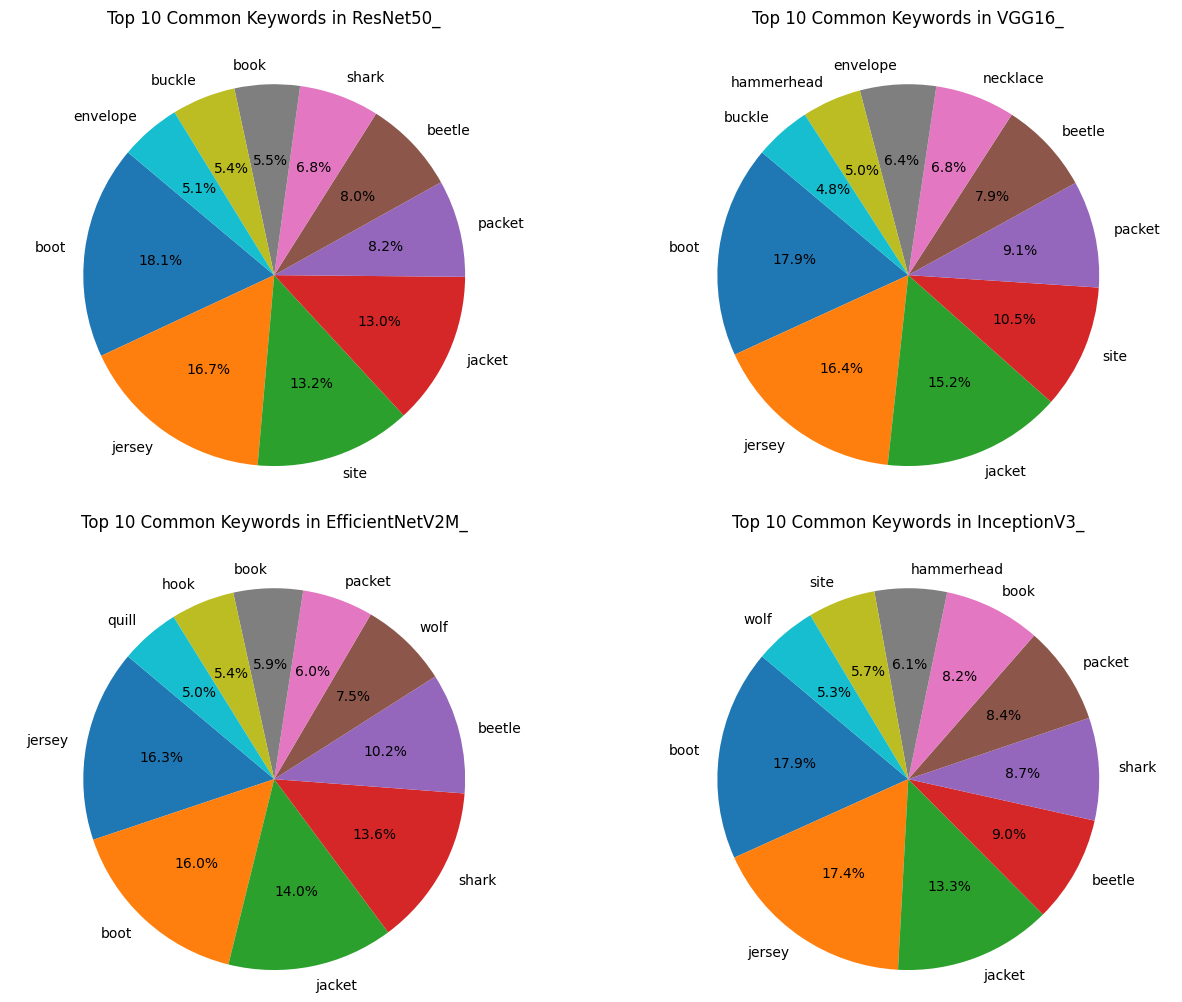

In [104]:
# Top 10 common keywords in a pie chart
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

def plot_top_10_pie_chart(ax, column_name, data_frame):
    top_10 = data_frame[column_name].apply(extract_last_element).value_counts().head(10)
    ax.pie(top_10, labels=top_10.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Top 10 Common Keywords in {column_name}', pad=30)
    ax.axis('equal')

plot_top_10_pie_chart(axs[0, 0], 'ResNet50_', df)
plot_top_10_pie_chart(axs[0, 1], 'VGG16_', df)
plot_top_10_pie_chart(axs[1, 0], 'EfficientNetV2M_', df)
plot_top_10_pie_chart(axs[1, 1], 'InceptionV3_', df)

plt.show()

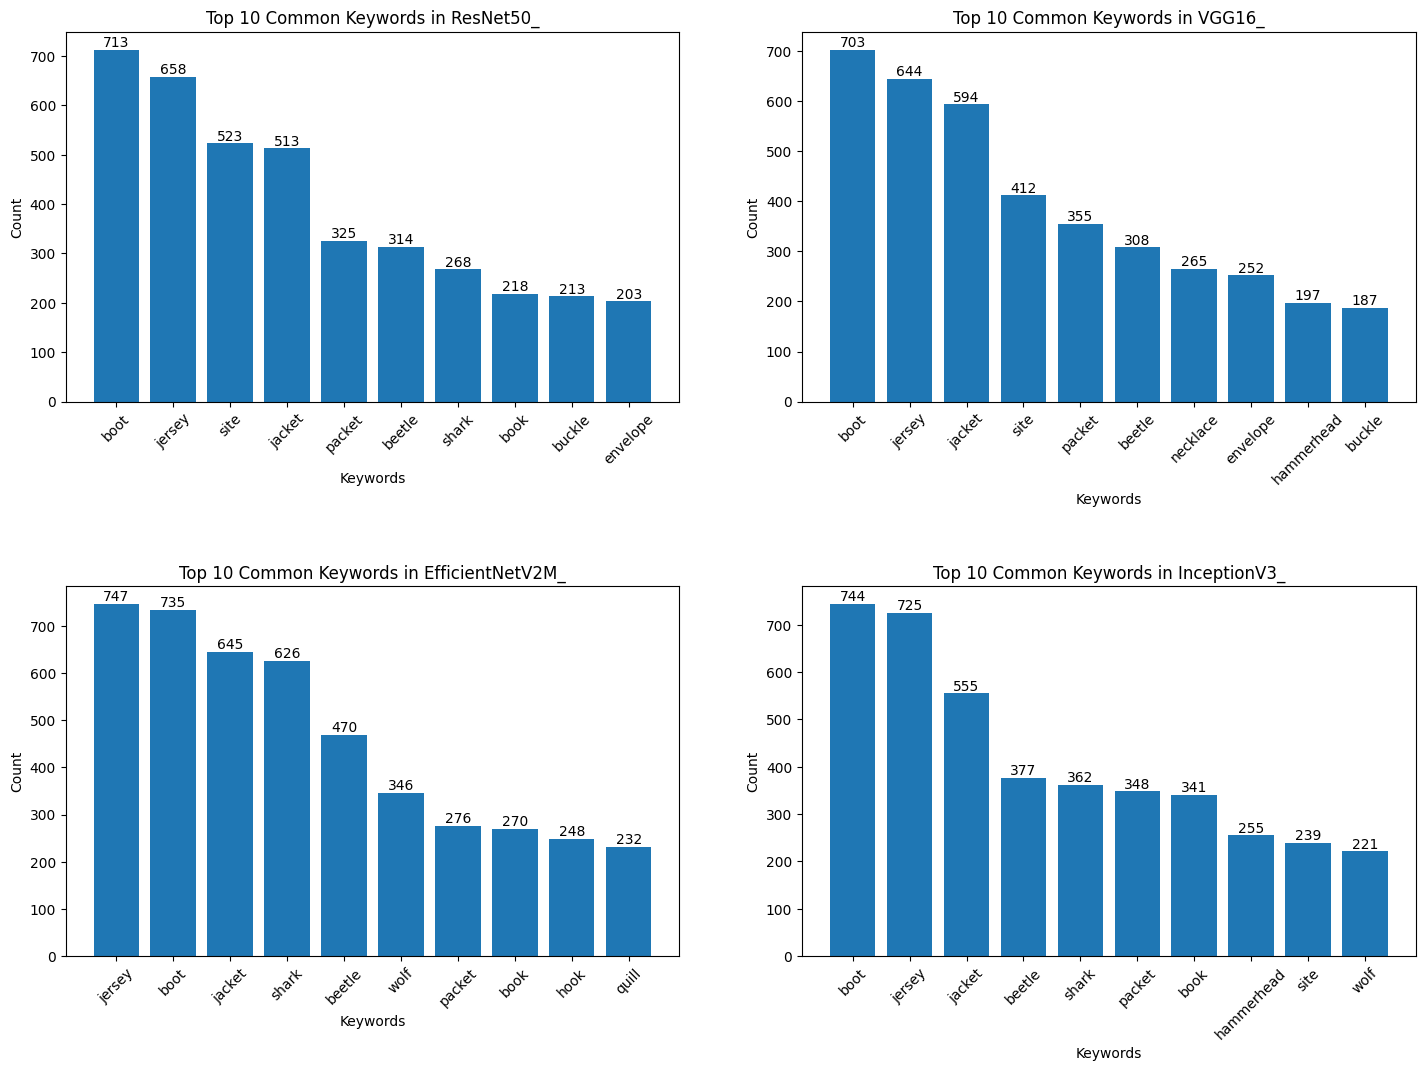

In [105]:
# Top 10 common keywords in a bar chart
def plot_top_10_bar_chart(ax, column_name, data_frame):
    top_10 = data_frame[column_name].apply(extract_last_element).value_counts().head(10)
    bars = ax.bar(top_10.index, top_10.values)
    ax.set_title(f'Top 10 Common Keywords in {column_name}')
    ax.set_xlabel('Keywords')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Creating a 2x2 matrix of subplots for bar charts
fig, axs = plt.subplots(2, 2, figsize=(15, 12), gridspec_kw={'hspace': 0.5, 'left': 0.05, 'right': 0.95})

plot_top_10_bar_chart(axs[0, 0], 'ResNet50_', df)
plot_top_10_bar_chart(axs[0, 1], 'VGG16_', df)
plot_top_10_bar_chart(axs[1, 0], 'EfficientNetV2M_', df)
plot_top_10_bar_chart(axs[1, 1], 'InceptionV3_', df)

plt.show()

# Extract predicted keywords
The new column 'combined_keyword' contains the most overlapped second element (keyword) from each row of the ResNet50_, VGG16_, EfficientNetV2M_, and InceptionV3_ columns. If there's a clear majority, only the most common keyword is selected; otherwise, all unique keywords are listed.

- For rows where one keyword is dominant (like 'shark' or 'bear'), only that keyword is listed.
- For rows with diverse keywords (like different animal names), all unique keywords are combined.

In [30]:
df = pd.read_csv('/content/drive/MyDrive/Big Data/Project/combined_models.csv')
df.head()

,ResNet50,VGG16,EfficientNetV2M,InceptionV3,ResNet50_,VGG16_,EfficientNetV2M_,InceptionV3_
0,mask,birdhouse,great_white_shark,great_white_shark,"mask, mask","birdhouse, birdhouse","great white shark, shark","great white shark, shark"
1,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle"
2,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle"
3,tiger_beetle,ground_beetle,ground_beetle,ground_beetle,"tiger beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle"
4,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle"


In [33]:
from collections import Counter

# Select the most overlapped keyword or list all if no overlap
def select_most_overlapped_keyword_specific_columns(row):
    specific_columns = ['ResNet50_', 'VGG16_', 'EfficientNetV2M_', 'InceptionV3_']
    keywords = [extract_last_element(row[col]) for col in specific_columns if not pd.isna(row[col])]

    if not keywords:  # If the list is empty (all values were NaN)
        return float('nan')  # Return NaN

    keyword_counts = Counter(keywords)
    most_common = keyword_counts.most_common()

    # If the most common keyword appears more than once, select it
    if most_common[0][1] > 1:
        return most_common[0][0]
    # Otherwise, return all unique keywords
    return ', '.join(set(keywords))

df['combined_keyword'] = df.apply(select_most_overlapped_keyword_specific_columns, axis=1)

df.to_csv('/content/drive/MyDrive/Big Data/Project/combined_models_keyword.csv', index=False)
df.head()

,ResNet50,VGG16,EfficientNetV2M,InceptionV3,ResNet50_,VGG16_,EfficientNetV2M_,InceptionV3_,combined_keyword
0,mask,birdhouse,great_white_shark,great_white_shark,"mask, mask","birdhouse, birdhouse","great white shark, shark","great white shark, shark",shark
1,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
2,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
3,tiger_beetle,ground_beetle,ground_beetle,ground_beetle,"tiger beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
4,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14437 entries, 0 to 14436
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ResNet50          14334 non-null  object
 1   VGG16             14334 non-null  object
 2   EfficientNetV2M   14334 non-null  object
 3   InceptionV3       14334 non-null  object
 4   ResNet50_         14334 non-null  object
 5   VGG16_            14334 non-null  object
 6   EfficientNetV2M_  14334 non-null  object
 7   InceptionV3_      14334 non-null  object
 8   combined_keyword  14419 non-null  object
dtypes: object(9)
memory usage: 1015.2+ KB


## The interesting insights about top-1 predictions of these 4 deep learning models
- **One Common Keyword (11,594 rows)**: This represents approximately 80.8% of the cases. In these instances, all four models either agreed on a single prediction or had no more than one unique prediction after processing the second element of each prediction. This high level of agreement suggests that for the majority of the data, the models are consistent in their predictions, indicating reliability and certainty in these particular instances.
- **More Than Two Keywords (2,825 rows)**: This accounts for approximately 19.7% of the cases.


In [117]:
df_with_multiple_keywords = df[df['combined_keyword'].str.split(',').str.len() > 1]

df_with_multiple_keywords

,ResNet50,VGG16,EfficientNetV2M,InceptionV3,ResNet50_,VGG16_,EfficientNetV2M_,InceptionV3_,combined_keyword
5,jigsaw_puzzle,coho,great_white_shark,comic_book,"jigsaw puzzle, puzzle","coho, coho","great white shark, shark","comic book, book","shark, coho, book, puzzle"
12,face_powder,cheetah,shield,doormat,"face powder, powder","cheetah, cheetah","shield, shield","doormat, doormat","cheetah, shield, doormat, powder"
14,buckle,doormat,jaguar,leopard,"buckle, buckle","doormat, doormat","jaguar, jaguar","leopard, leopard","buckle, leopard, doormat, jaguar"
16,sundial,sombrero,timber_wolf,shield,"sundial, sundial","sombrero, sombrero","timber wolf, wolf","shield, shield","wolf, sundial, sombrero, shield"
20,ibex,corkscrew,gazelle,book_jacket,"ibex, ibex","corkscrew, corkscrew","gazelle, gazelle","book jacket, jacket","gazelle, corkscrew, jacket, ibex"
...,...,...,...,...,...,...,...,...,...
14422,trilobite,tick,barn_spider,black_widow,"trilobite, trilobite","tick, tick","barn spider, spider","black widow, widow","widow, spider, tick, trilobite"
14425,quill,acorn,sea_urchin,conch,"quill, quill","acorn, acorn","sea urchin, urchin","conch, conch","acorn, urchin, conch, quill"
14427,strainer,dam,handkerchief,stole,"strainer, strainer","dam, dam","handkerchief, handkerchief","stole, stole","dam, strainer, stole, handkerchief"
14428,stole,horned_viper,conch,ocarina,"stole, stole","horned viper, viper","conch, conch","ocarina, ocarina","conch, viper, stole, ocarina"


In [118]:
df_with_one_keywords = df[df['combined_keyword'].str.split(',').str.len() < 2]

df_with_one_keywords

,ResNet50,VGG16,EfficientNetV2M,InceptionV3,ResNet50_,VGG16_,EfficientNetV2M_,InceptionV3_,combined_keyword
0,mask,birdhouse,great_white_shark,great_white_shark,"mask, mask","birdhouse, birdhouse","great white shark, shark","great white shark, shark",shark
1,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
2,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
3,tiger_beetle,ground_beetle,ground_beetle,ground_beetle,"tiger beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
4,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
...,...,...,...,...,...,...,...,...,...
14431,necklace,NaN,NaN,NaN,"necklace, necklace",NaN,NaN,NaN,necklace
14432,mailbag,purse,purse,mailbag,"mailbag, mailbag","purse, purse","purse, purse","mailbag, mailbag",mailbag
14433,slug,conch,conch,conch,"slug, slug","conch, conch","conch, conch","conch, conch",conch
14434,bulletproof_vest,cliff,swab,bulletproof_vest,"bulletproof vest, vest","cliff, cliff","swab, swab","bulletproof vest, vest",vest


## Extract keywords relevant to animal species
> Reference: https://checklist.cites.org/#/en

We need to define a list of keywords that considered relevant to animal species. This list will be used to filter and extract the relevant keywords from each entry in the 'combined_keyword' column.


### Creating a List of Specific Animal Names
1. Filter by Kingdom is "Animalia"
2. Make a Species Name List from "EnglishNames"

In [4]:
file_path = '/content/drive/MyDrive/Big Data/Project/Species-EnglishNames.csv'
species_df = pd.read_csv(file_path, low_memory=False)

In [5]:
animalia_df = species_df[species_df['Kingdom'] == 'Animalia']
non_null_count = animalia_df['EnglishNames'].notnull().sum()

print(non_null_count)

4366


In [7]:
# Filter for 'Animalia' in the 'Kingdom' column
animalia_df = species_df[species_df['Kingdom'] == 'Animalia'][['EnglishNames', 'All_DistributionFullNames']]

# Define the function to split names
def split_names(names):
    if isinstance(names, float):  # Checking for NaN
        return []
    return [name.strip() for name in names.split(',')]

animalia_df['Split Names'] = animalia_df['EnglishNames'].apply(split_names)
animal_list_df = animalia_df.explode('Split Names').rename(columns={'Split Names': 'Specific Names'})

# Dropping NaN values in 'Specific Names'
animal_list_df = animal_list_df.dropna(subset=['Specific Names'])

# Dropping the now-redundant 'EnglishNames' column
animal_list_df.drop(['EnglishNames'], axis=1, inplace=True)

# 8752 rows
animal_list_df.to_csv('/content/drive/MyDrive/Big Data/Project/animal_list.csv', index=False)
animal_list_df

,All_DistributionFullNames,Specific Names
1,"El Salvador, Guatemala, Honduras, Mexico, Nica...",Emerald-chinned Hummingbird
3,Guatemala,Anzuetoi arboreal alligator lizard
5,Mexico,Bogert's arboreal alligator lizard
6,Guatemala,Campbell's alligator lizard
7,Mexico,Chiszar's Arboreal Alligator Lizard
...,...,...
7784,Australia,Central Australian rock rat
7784,Australia,Central rock-rat
7784,Australia,Central Rock Rat
7784,Australia,Central Thick-tailed Rock Rat


In [131]:
# 8489 rows
len(animal_list_df['Specific Names'].unique())

8489

Since there are some duplicate values in 'Specific Names', we will normalize the values in this column and remove the duplicates.
- Central rock-rat
- Central Rock Rat

In [8]:
# Check non-alphabet characters
non_alpha_chars = animal_list_df['Specific Names'].str.extractall(r'([^A-Za-z\s])')[0].unique()

non_alpha_chars

array(['-', "'", 'í', 'é', 'ô', '.', '’', 'á', '(', ')', '/', 'ü', '`',
       '́', 'ö', 'è', 'ó', 'ú', 'ç', 'ñ'], dtype=object)

In [9]:
specified_chars = ["(", ")", "/", ".", "`", "́"]
filtered_rows_individual = animal_list_df[animal_list_df['Specific Names'].apply(lambda x: any(char in x for char in specified_chars))]

filtered_rows_individual

,All_DistributionFullNames,Specific Names
564,Saint Vincent and the Grenadines,St. vincent amazon
564,Saint Vincent and the Grenadines,St. vincent parrot
575,Saint Lucia,St. lucia amazon
575,Saint Lucia,St. lucia parrot
686,Australia,Children's (Rock) Python
984,Kenya,Mt. Kenya bush viper
987,Sri Lanka,Sri lankan/ceylon rose
1355,Colombia,Rio Apaporis (Spectacled) Caiman
1709,Sri Lanka,Karunaratne's (horn) lizard
1709,Sri Lanka,Karu's (horned) lizard


In [10]:
animal_list_df = pd.read_csv('/content/drive/MyDrive/Big Data/Project/animal_list.csv')
animal_list_df

,All_DistributionFullNames,Specific Names
0,"El Salvador, Guatemala, Honduras, Mexico, Nica...",Emerald-chinned Hummingbird
1,Guatemala,Anzuetoi arboreal alligator lizard
2,Mexico,Bogert's arboreal alligator lizard
3,Guatemala,Campbell's alligator lizard
4,Mexico,Chiszar's Arboreal Alligator Lizard
...,...,...
8747,Australia,Central Australian rock rat
8748,Australia,Central rock-rat
8749,Australia,Central Rock Rat
8750,Australia,Central Thick-tailed Rock Rat


In [11]:
import unicodedata

def normalize_name(name):
    name = name.lower()

    # Replacing specified characters
    name = name.replace('’', "'").replace('`', "'")

    # Normalizing non-standard characters to closest ASCII representation
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('ascii')

    # Keeping only alphabets and spaces
    name = ''.join([char for char in name if char.isalpha() or char.isspace()])

    return name

In [12]:
# Step 1: Remove all special characters including numbers, keep only lowercase alphabets
def remove_special_characters(name):
    return ''.join([char.lower() for char in name if char.isalpha()])

animal_list_df['Specific Names_'] = animal_list_df['Specific Names'].apply(remove_special_characters)

# Step 2: Keep the row with the most special characters in case of duplicates
# Central rock-rat > Central Rock Rat
animal_list_df['Special Char Count'] = animal_list_df['Specific Names'].apply(lambda x: len([char for char in x if not char.isalpha() and not char.isspace()]))
animal_list_df.sort_values(by=['Specific Names_', 'Special Char Count'], ascending=[True, False], inplace=True)

# Dropping duplicates, keeping the one with the most special characters
animal_list_df.drop_duplicates(subset=['Specific Names_'], keep='first', inplace=True)
animal_list_df.reset_index(drop=True, inplace=True)

# Step 3: Apply the normalize_name function
animal_list_df['Specific Names Normalized'] = animal_list_df['Specific Names'].apply(normalize_name)

animal_list_df

,All_DistributionFullNames,Specific Names,Specific Names_,Special Char Count,Specific Names Normalized
0,"Angola, Botswana, Central African Republic, Dj...",Aardwolf,aardwolf,0,aardwolf
1,Bahamas,Abaco Island Boa,abacoislandboa,0,abaco island boa
2,"Australia, Christmas Island, Indonesia, Maurit...",Abbott's Booby,abbottsbooby,1,abbotts booby
3,"Madagascar, Seychelles",Abbott's Day Gecko,abbottsdaygecko,1,abbotts day gecko
4,Italy,Abruzzo Chamois,abruzzochamois,0,abruzzo chamois
...,...,...,...,...,...
8125,"Malawi, Mozambique, United Republic of Tanzania",Zomba pygmy chameleon,zombapygmychameleon,0,zomba pygmy chameleon
8126,"Argentina, Belize, Bolivia (Plurinational Stat...",Zone-tailed Hawk,zonetailedhawk,1,zonetailed hawk
8127,"Albania, Algeria, Angola, Argentina, Australia...",Zorro thresher shark,zorrothreshershark,0,zorro thresher shark
8128,"Eswatini, Mozambique, South Africa",Zoutpansberg Girdled Lizard,zoutpansberggirdledlizard,0,zoutpansberg girdled lizard


In [13]:
animal_list_df.to_csv('/content/drive/MyDrive/Big Data/Project/specific_animal_list_normalized.csv', index=False)

- Before normalization: 8752 rows
- After normalization: 8130 rows

### Creating a List of General Animal Names
From the 'Specific Names Normalized' column, we can extract the last word.

In [14]:
animal_list_df = pd.read_csv('/content/drive/MyDrive/Big Data/Project/specific_animal_list_normalized.csv')
animal_list_df

,All_DistributionFullNames,Specific Names,Specific Names_,Special Char Count,Specific Names Normalized
0,"Angola, Botswana, Central African Republic, Dj...",Aardwolf,aardwolf,0,aardwolf
1,Bahamas,Abaco Island Boa,abacoislandboa,0,abaco island boa
2,"Australia, Christmas Island, Indonesia, Maurit...",Abbott's Booby,abbottsbooby,1,abbotts booby
3,"Madagascar, Seychelles",Abbott's Day Gecko,abbottsdaygecko,1,abbotts day gecko
4,Italy,Abruzzo Chamois,abruzzochamois,0,abruzzo chamois
...,...,...,...,...,...
8125,"Malawi, Mozambique, United Republic of Tanzania",Zomba pygmy chameleon,zombapygmychameleon,0,zomba pygmy chameleon
8126,"Argentina, Belize, Bolivia (Plurinational Stat...",Zone-tailed Hawk,zonetailedhawk,1,zonetailed hawk
8127,"Albania, Algeria, Angola, Argentina, Australia...",Zorro thresher shark,zorrothreshershark,0,zorro thresher shark
8128,"Eswatini, Mozambique, South Africa",Zoutpansberg Girdled Lizard,zoutpansberggirdledlizard,0,zoutpansberg girdled lizard


In [17]:
# Extracting the last word for the 'General Names Normalized' column
animal_list_df['General Names Normalized'] = animal_list_df['Specific Names Normalized'].apply(lambda x: x.split()[-1] if x else None)

animal_list_df[['Specific Names Normalized', 'General Names Normalized']]

,Specific Names Normalized,General Names Normalized
0,aardwolf,aardwolf
1,abaco island boa,boa
2,abbotts booby,booby
3,abbotts day gecko,gecko
4,abruzzo chamois,chamois
...,...,...
8125,zomba pygmy chameleon,chameleon
8126,zonetailed hawk,hawk
8127,zorro thresher shark,shark
8128,zoutpansberg girdled lizard,lizard


In [19]:
unique_general_species = animal_list_df['General Names Normalized'].unique()
unique_general_species

array(['aardwolf', 'boa', 'booby', 'gecko', 'chamois', 'owl', 'lovebird',
       'tarantula', 'achoque', 'iguana', 'eagle', 'addax', 'gazelle',
       'cuscus', 'flyingfox', 'hawkowl', 'coquette', 'sturgeon', 'fox',
       'tortoise', 'urial', 'ass', 'owlet', 'baza', 'barb', 'fish',
       'python', 'caracal', 'chameleon', 'civet', 'otter', 'duck',
       'crocodile', 'cuckoofalcon', 'cuckoohawk', 'eagleowl', 'elephant',
       'fisheagle', 'cat', 'goshawk', 'grassowl', 'parrot', 'gymnogene',
       'harrierhawk', 'hawkeagle', 'hobby', 'houbara', 'bustard',
       'lizard', 'lion', 'sparrowhawk', 'hawk', 'manatee', 'marshharrier',
       'penguin', 'coral', 'pygmyfalcon', 'buzzard', 'monitor',
       'scopsowl', 'serpenteagle', 'turtle', 'kite', 'wedgefish',
       'vulture', 'woodowl', 'seal', 'gibbon', 'mangabey', 'agouti',
       'lampmussel', 'naiad', 'mussel', 'curassow', 'toad', 'lemur',
       'goose', 'parakeet', 'mouse', 'bushbaby', 'galago', 'hummingbird',
       'monkey', 'a

In [20]:
len(unique_general_species)

906

We can conclude that, according to CITES (the Convention on International Trade in Endangered Species of Wild Fauna and Flora), there are 906 general animal species classified as endangered.

In [21]:
animal_list_df.to_csv('/content/drive/MyDrive/Big Data/Project/final_animal_list_normalized', index=False)
animal_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8130 entries, 0 to 8129
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   All_DistributionFullNames  8047 non-null   object
 1   Specific Names             8130 non-null   object
 2   Specific Names_            8130 non-null   object
 3   Special Char Count         8130 non-null   int64 
 4   Specific Names Normalized  8130 non-null   object
 5   General Names Normalized   8130 non-null   object
dtypes: int64(1), object(5)
memory usage: 381.2+ KB


In [27]:
# Dropping the specified columns
animal_list_df = animal_list_df.drop(['Specific Names_', 'Special Char Count'], axis=1)
animal_list_df = animal_list_df.rename(columns={'All_DistributionFullNames': 'Distribution Country'})

csv_file_path = '/content/drive/MyDrive/Big Data/Team Notebook/data/final_animal_list.csv'
animal_list_df.to_csv(csv_file_path, index=False)

### Fuzzy Matching (String Similarity)
> Fuzzy matching algorithms, particularly those used in libraries like rapidfuzz or fuzzywuzzy, are generally designed to handle variations in case (uppercase vs. lowercase) and can effectively manage minor typos or variations in the spelling of words. This capability is part of what makes fuzzy matching useful for comparing strings where exact matches are not expected due to inconsistencies or human error in the data.

Fuzzy matching algorithms often rely on string **similarity metrics**, such as Levenshtein Distance, Jaro-Winkler, or Cosine Similarity. These metrics calculate a score based on how many edits (additions, deletions, substitutions) are required to transform one string into another, or they measure the similarity in character sequences.

One of the most common metrics used in fuzzy matching is the **Levenshtein Distance**. It measures the minimum number of single-character edits required to change one word into another. The lower the number, the more similar the two strings are.


In [29]:
animal_df = pd.read_csv('/content/drive/MyDrive/Big Data/Team Notebook/data/final_animal_list.csv')
animal_df.head()

,Distribution Country,Specific Names,Specific Names Normalized,General Names Normalized
0,"Angola, Botswana, Central African Republic, Dj...",Aardwolf,aardwolf,aardwolf
1,Bahamas,Abaco Island Boa,abaco island boa,boa
2,"Australia, Christmas Island, Indonesia, Maurit...",Abbott's Booby,abbotts booby,booby
3,"Madagascar, Seychelles",Abbott's Day Gecko,abbotts day gecko,gecko
4,Italy,Abruzzo Chamois,abruzzo chamois,chamois


In [35]:
combined_df = pd.read_csv('/content/drive/MyDrive/Big Data/Project/combined_models_keyword.csv')
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14437 entries, 0 to 14436
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ResNet50          14334 non-null  object
 1   VGG16             14334 non-null  object
 2   EfficientNetV2M   14334 non-null  object
 3   InceptionV3       14334 non-null  object
 4   ResNet50_         14334 non-null  object
 5   VGG16_            14334 non-null  object
 6   EfficientNetV2M_  14334 non-null  object
 7   InceptionV3_      14334 non-null  object
 8   combined_keyword  14419 non-null  object
dtypes: object(9)
memory usage: 1015.2+ KB


In [36]:
combined_df.head(10)

,ResNet50,VGG16,EfficientNetV2M,InceptionV3,ResNet50_,VGG16_,EfficientNetV2M_,InceptionV3_,combined_keyword
0,mask,birdhouse,great_white_shark,great_white_shark,"mask, mask","birdhouse, birdhouse","great white shark, shark","great white shark, shark",shark
1,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
2,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
3,tiger_beetle,ground_beetle,ground_beetle,ground_beetle,"tiger beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
4,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
5,jigsaw_puzzle,coho,great_white_shark,comic_book,"jigsaw puzzle, puzzle","coho, coho","great white shark, shark","comic book, book","shark, coho, puzzle, book"
6,ground_beetle,ground_beetle,ground_beetle,ground_beetle,"ground beetle, beetle","ground beetle, beetle","ground beetle, beetle","ground beetle, beetle",beetle
7,buckle,shield,chambered_nautilus,chambered_nautilus,"buckle, buckle","shield, shield","chambered nautilus, nautilus","chambered nautilus, nautilus",nautilus
8,pitcher,buckle,triceratops,buckle,"pitcher, pitcher","buckle, buckle","triceratops, triceratops","buckle, buckle",buckle
9,magnetic_compass,magnetic_compass,puck,puck,"magnetic compass, compass","magnetic compass, compass","puck, puck","puck, puck",compass


In the code below, `rapidfuzz.process.extract` finds the best matches from `animal_df['General Names Normalized']` for each unique keyword in `combined_df['combined_keyword']`.

- **animal_df**: Contains the specific animal species names and general animal species names, which are derived from the former column.
- **combined_df**: Represents the most commonly predicted keywords from four deep learning models. It can contain multiple keywords in a single record.

In [48]:
from rapidfuzz import process, fuzz

# Find best matches
def find_matches(query, choices, limit=1, score_cutoff=80):
    return process.extract(query, choices, scorer=fuzz.WRatio, limit=limit, score_cutoff=score_cutoff)

#### combined_keyword & General Names Normalized

In [50]:
results_general = []

# Loop through each unique keyword and find the best match
for keyword in combined_df['combined_keyword'].unique():
    matches = find_matches(keyword, animal_df['General Names Normalized'].unique())
    for match in matches:
        matched_name, score, _ = match
        results_general.append({'combined_keyword': keyword, 'general_name': matched_name, 'score_combined_general': score})

result_general_df = pd.DataFrame(results_general, columns=['combined_keyword', 'general_name', 'score_combined_general'])
result_general_df.head()

,combined_keyword,general_name,score_combined_general
0,shark,shark,100.0
1,beetle,beetle,100.0
2,"shark, coho, puzzle, book",shark,90.0
3,compass,ass,90.0
4,sunglasses,ass,90.0


#### ResNet50_ & Specific Names Normalized

In [51]:
results_resnet_specific = []

# Loop through each unique keyword and find the best match
for keyword in combined_df['ResNet50_'].unique():
    matches = find_matches(keyword, animal_df['Specific Names Normalized'].unique())
    for match in matches:
        matched_name, score, _ = match
        results_resnet_specific.append({'resnet50_keyword': keyword, 'specific_name': matched_name, 'score_resnet50_specific': score})

results_resnet_specific_df = pd.DataFrame(results_resnet_specific, columns=['resnet50_keyword', 'specific_name', 'score_resnet50_specific'])
results_resnet_specific_df.head()

,resnet50_keyword,specific_name,score_resnet50_specific
0,"ground beetle, beetle",grandidiers madagascar ground gecko,85.5
1,"tiger beetle, beetle",tiger,90.0
2,"sunglasses, sunglasses",ass,90.0
3,"hammerhead, hammerhead",hammerhead,90.0
4,"black widow, widow",argentine black and white tegu,85.5


#### VGG16_ & Specific Names Normalized

In [52]:
results_vgg_specific = []

# Loop through each unique keyword and find the best match
for keyword in combined_df['VGG16_'].unique():
    matches = find_matches(keyword, animal_df['Specific Names Normalized'].unique())
    for match in matches:
        matched_name, score, _ = match
        results_vgg_specific.append({'vgg16_keyword': keyword, 'specific_name': matched_name, 'score_vgg16_specific': score})

results_vgg_specific_df = pd.DataFrame(results_vgg_specific, columns=['vgg16_keyword', 'specific_name', 'score_vgg16_specific'])
results_vgg_specific_df.head()

,vgg16_keyword,specific_name,score_vgg16_specific
0,"ground beetle, beetle",grandidiers madagascar ground gecko,85.5
1,"cheetah, cheetah",cheetah,90.0
2,"night snake, snake",central american coral snake,85.5
3,"brown bear, bear",brown bear,90.0
4,"cocktail shaker, shaker",saker,80.0


#### EfficientNetV2M_ & Specific Names Normalized



In [53]:
results_efficientNet_specific = []

# Loop through each unique keyword and find the best match
for keyword in combined_df['EfficientNetV2M_'].unique():
    matches = find_matches(keyword, animal_df['Specific Names Normalized'].unique())
    for match in matches:
        matched_name, score, _ = match
        results_efficientNet_specific.append({'efficientNetV2M_keyword': keyword, 'specific_name': matched_name, 'score_efficientNetV2M_specific': score})

results_efficientNet_specific_df = pd.DataFrame(results_efficientNet_specific, columns=['efficientNetV2M_keyword', 'specific_name', 'score_efficientNetV2M_specific'])
results_efficientNet_specific_df.head()

,efficientNetV2M_keyword,specific_name,score_efficientNetV2M_specific
0,"great white shark, shark",great white shark,95.0
1,"ground beetle, beetle",grandidiers madagascar ground gecko,85.5
2,"sunglasses, sunglasses",ass,90.0
3,"horned viper, viper",horned guan,85.5
4,"jaguar, jaguar",jaguar,90.0


#### InceptionV3_	& Specific Names Normalized

In [54]:
results_inception_specific = []

# Loop through each unique keyword and find the best match
for keyword in combined_df['InceptionV3_'].unique():
    matches = find_matches(keyword, animal_df['Specific Names Normalized'].unique())
    for match in matches:
        matched_name, score, _ = match
        results_inception_specific.append({'inceptionV3_keyword': keyword, 'specific_name': matched_name, 'score_inceptionV3_specific': score})

results_inception_specific_df = pd.DataFrame(results_inception_specific, columns=['inceptionV3_keyword', 'specific_name', 'score_inceptionV3_specific'])
results_inception_specific_df.head()

,inceptionV3_keyword,specific_name,score_inceptionV3_specific
0,"great white shark, shark",great white shark,95.0
1,"ground beetle, beetle",grandidiers madagascar ground gecko,85.5
2,"sunglass, sunglass",ass,90.0
3,"leopard, leopard",leopard,90.0
4,"brown bear, bear",brown bear,90.0


#### Combine multiple dataframes into a single dataframe


In [55]:
result_df = pd.concat([result_general_df,
                       results_resnet_specific_df,
                       results_vgg_specific_df,
                       results_efficientNet_specific_df,
                       results_inception_specific_df],
                      ignore_index=True)

result_df.to_csv('/content/drive/MyDrive/Big Data/Team Notebook/data/image_classification.csv', index=False)
result_df

,combined_keyword,general_name,score_combined_general,resnet50_keyword,specific_name,score_resnet50_specific,vgg16_keyword,score_vgg16_specific,efficientNetV2M_keyword,score_efficientNetV2M_specific,inceptionV3_keyword,score_inceptionV3_specific
0,shark,shark,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,beetle,beetle,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"shark, coho, puzzle, book",shark,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,compass,ass,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sunglasses,ass,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2338,NaN,NaN,NaN,NaN,truck wrasse,NaN,NaN,NaN,NaN,NaN,"garbage truck, truck",85.500000
2339,NaN,NaN,NaN,NaN,cougar,NaN,NaN,NaN,NaN,NaN,"cougar, cougar",90.000000
2340,NaN,NaN,NaN,NaN,indris,NaN,NaN,NaN,NaN,NaN,"indri, indri",81.818182
2341,NaN,NaN,NaN,NaN,ass,NaN,NaN,NaN,NaN,NaN,"passenger car, car",90.000000


## Animal Species Analysis

### Top-10 Species: Figures

In [86]:
sorted_df_combined_general = result_general_df.sort_values(by='score_combined_general', ascending=False)
sorted_df_combined_general.head(10)

,combined_keyword,general_name,score_combined_general
0,shark,shark,100.0
1168,pointer,pointer,100.0
163,ox,ox,100.0
165,panda,panda,100.0
172,tiger,tiger,100.0
175,lorikeet,lorikeet,100.0
180,snail,snail,100.0
532,weasel,weasel,100.0
183,stingray,stingray,100.0
853,thresher,thresher,100.0


In [87]:
sorted_df_resnet_specific = results_resnet_specific_df.sort_values(by='score_resnet50_specific', ascending=False)
sorted_df_resnet_specific.head(10)

,resnet50_keyword,specific_name,score_resnet50_specific
103,"leatherback turtle, turtle",leatherback turtle,95.0
8,"great white shark, shark",great white shark,95.0
63,"great grey owl, owl",great grey owl,95.0
69,"vulture, vulture",tur,90.0
190,"gorilla, gorilla",gorilla,90.0
84,"brassiere, brassiere",ass,90.0
83,"orangutan, orangutan",ora,90.0
78,"hippopotamus, hippopotamus",hippopotamus,90.0
183,"assault rifle, rifle",ass,90.0
185,"drumstick, drumstick",drum,90.0


In [88]:
sorted_df_vgg_specific = results_vgg_specific_df.sort_values(by='score_vgg16_specific', ascending=False)
sorted_df_vgg_specific.head(10)

,vgg16_keyword,specific_name,score_vgg16_specific
95,"leatherback turtle, turtle",leatherback turtle,95.0
224,"great grey owl, owl",great grey owl,95.0
42,"great white shark, shark",great white shark,95.0
247,"passenger car, car",ass,90.0
188,"goldfinch, goldfinch",goldfinch,90.0
91,"brassiere, brassiere",ass,90.0
179,"basset, basset",ass,90.0
87,"malinois, malinois",mal,90.0
86,"bearskin, bearskin",bears,90.0
84,"giant panda, panda",giant panda,90.0


In [89]:
sorted_df_efficient_specific = results_efficientNet_specific_df.sort_values(by='score_efficientNetV2M_specific', ascending=False)
sorted_df_efficient_specific.head(10)

,efficientNetV2M_keyword,specific_name,score_efficientNetV2M_specific
0,"great white shark, shark",great white shark,95.0
195,"great grey owl, owl",great grey owl,95.0
85,"leatherback turtle, turtle",leatherback turtle,95.0
69,"killer whale, whale",killer whale,90.0
83,"red wolf, wolf",wolf,90.0
164,"bearskin, bearskin",bears,90.0
165,"car wheel, wheel",eel,90.0
77,"eel, eel",eel,90.0
76,"hippopotamus, hippopotamus",hippopotamus,90.0
74,"cheetah, cheetah",cheetah,90.0


In [90]:
sorted_df_inception_specific = results_inception_specific_df.sort_values(by='score_inceptionV3_specific', ascending=False)
sorted_df_inception_specific.head(10)

,inceptionV3_keyword,specific_name,score_inceptionV3_specific
0,"great white shark, shark",great white shark,95.0
38,"leatherback turtle, turtle",leatherback turtle,95.0
117,"great grey owl, owl",great grey owl,95.0
88,"cassette, cassette",ass,90.0
185,"gorilla, gorilla",gorilla,90.0
187,"potter's wheel, wheel",eel,90.0
82,"brassiere, brassiere",ass,90.0
81,"malamute, malamute",mal,90.0
189,"cassette player, player",ass,90.0
78,"hippopotamus, hippopotamus",hippopotamus,90.0


The name(s) that appear most frequently across these dataframes:
- **General species**: shark
- **Specific species**: leatherback turtle

In [83]:
# Function to get the last word of a string
def get_last_word(name):
    return name.split()[-1] if isinstance(name, str) and name else name

In [82]:
# General speecies
top_name_combined_general = sorted_df_combined_general['general_name'].iloc[0]
top_name_resnet_specific = get_last_word(sorted_df_resnet_specific['specific_name'].iloc[0])
top_name_vgg_specific = get_last_word(sorted_df_vgg_specific['specific_name'].iloc[0])
top_name_efficient_specific = get_last_word(sorted_df_efficient_specific['specific_name'].iloc[0])
top_name_inception_specific = get_last_word(sorted_df_inception_specific['specific_name'].iloc[0])

top_names = [top_name_combined_general, top_name_resnet_specific, top_name_vgg_specific, top_name_efficient_specific, top_name_inception_specific]

from collections import Counter
name_counts = Counter(top_names)

most_common_name, count = name_counts.most_common(1)[0]
print(f"The most common general species is '{most_common_name}', appearing {count} times.")

The most common general species is 'shark', appearing 3 times.


In [81]:
# Specific species
top_name_resnet_specific = sorted_df_resnet_specific['specific_name'].iloc[0]
top_name_vgg_specific = sorted_df_vgg_specific['specific_name'].iloc[0]
top_name_efficient_specific = sorted_df_efficient_specific['specific_name'].iloc[0]
top_name_inception_specific = sorted_df_inception_specific['specific_name'].iloc[0]

top_names = [top_name_resnet_specific, top_name_vgg_specific, top_name_efficient_specific, top_name_inception_specific]

from collections import Counter
name_counts = Counter(top_names)

most_common_name, count = name_counts.most_common(1)[0]
print(f"The most common specific species is '{most_common_name}' appearing {count} times.")

The most common specific species is 'leatherback turtle' appearing 2 times.


### Top-10 Species: Visualization

In [96]:
import matplotlib.pyplot as plt

def get_last_word(name):
    return name.split()[-1] if isinstance(name, str) else name

# For general species - consider the last word for specific dataframes
general_top10_combined = sorted_df_combined_general['general_name'].value_counts().head(10)
general_top10_resnet = sorted_df_resnet_specific['specific_name'].apply(get_last_word).value_counts().head(10)
general_top10_vgg = sorted_df_vgg_specific['specific_name'].apply(get_last_word).value_counts().head(10)
general_top10_efficient = sorted_df_efficient_specific['specific_name'].apply(get_last_word).value_counts().head(10)
general_top10_inception = sorted_df_inception_specific['specific_name'].apply(get_last_word).value_counts().head(10)

# For specific species
specific_top10_resnet = sorted_df_resnet_specific['specific_name'].value_counts().head(10)
specific_top10_vgg = sorted_df_vgg_specific['specific_name'].value_counts().head(10)
specific_top10_efficient = sorted_df_efficient_specific['specific_name'].value_counts().head(10)
specific_top10_inception = sorted_df_inception_specific['specific_name'].value_counts().head(10)

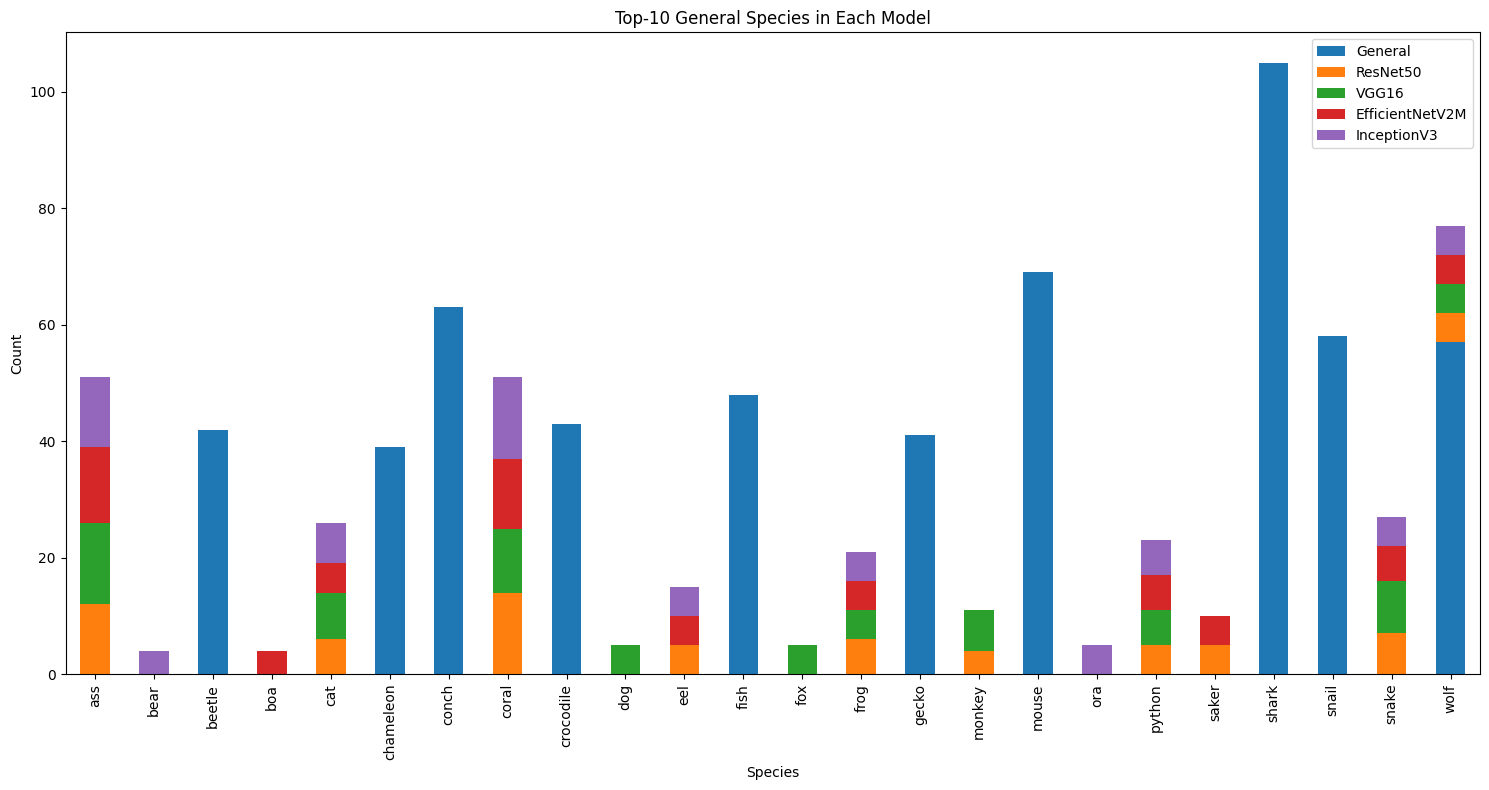

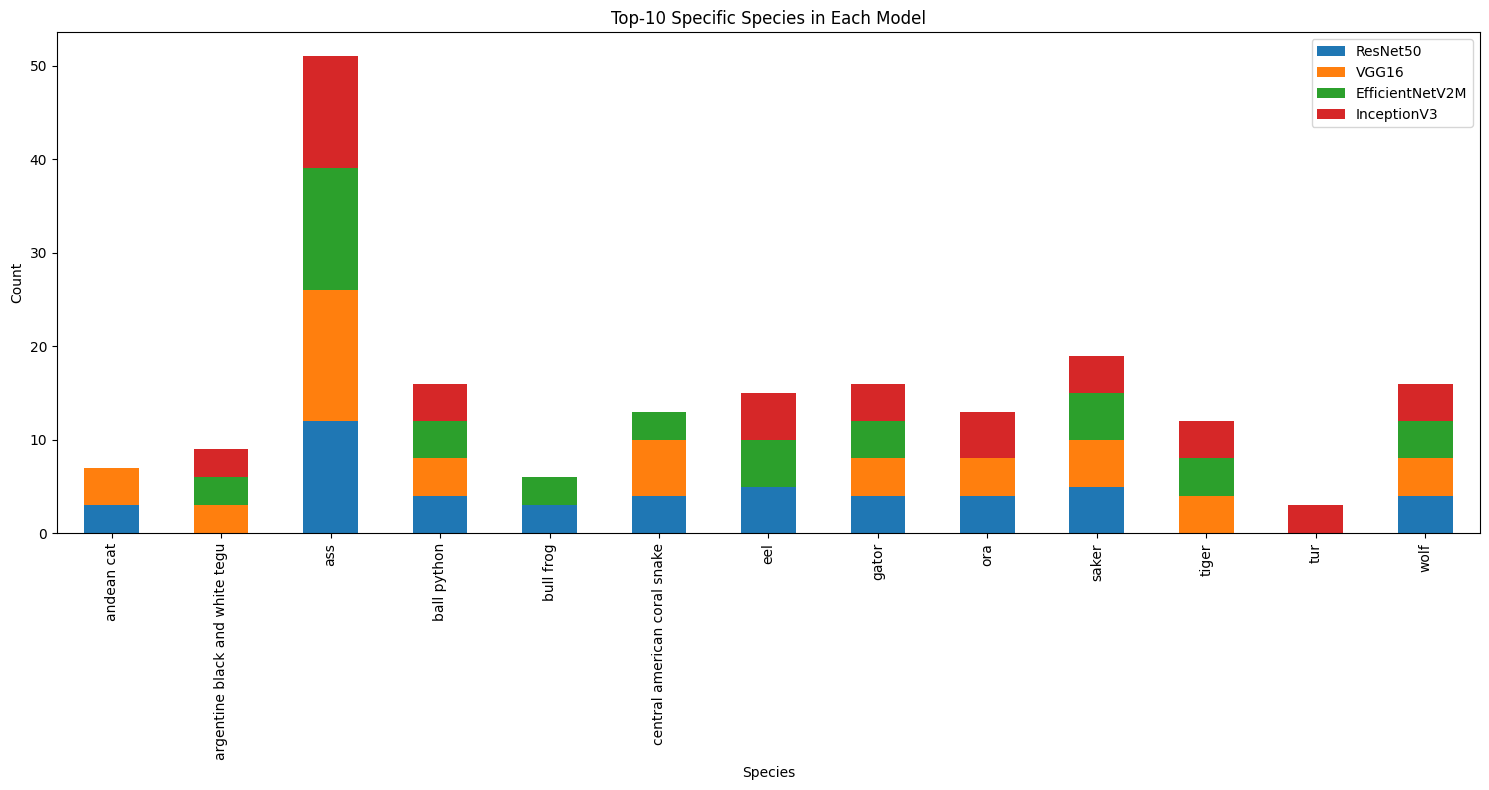

In [99]:
general_data = pd.DataFrame({
    'General': general_top10_combined,
    'ResNet50': general_top10_resnet,
    'VGG16': general_top10_vgg,
    'EfficientNetV2M': general_top10_efficient,
    'InceptionV3': general_top10_inception
}).fillna(0)

specific_data = pd.DataFrame({
    'ResNet50': specific_top10_resnet,
    'VGG16': specific_top10_vgg,
    'EfficientNetV2M': specific_top10_efficient,
    'InceptionV3': specific_top10_inception
}).fillna(0)

def plot_top10_species(data, title):
    data.plot(kind='bar', stacked=True, figsize=(15, 8))
    plt.xlabel('Species')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_top10_species(general_data, 'Top-10 General Species in Each Model')
plot_top10_species(specific_data, 'Top-10 Specific Species in Each Model')

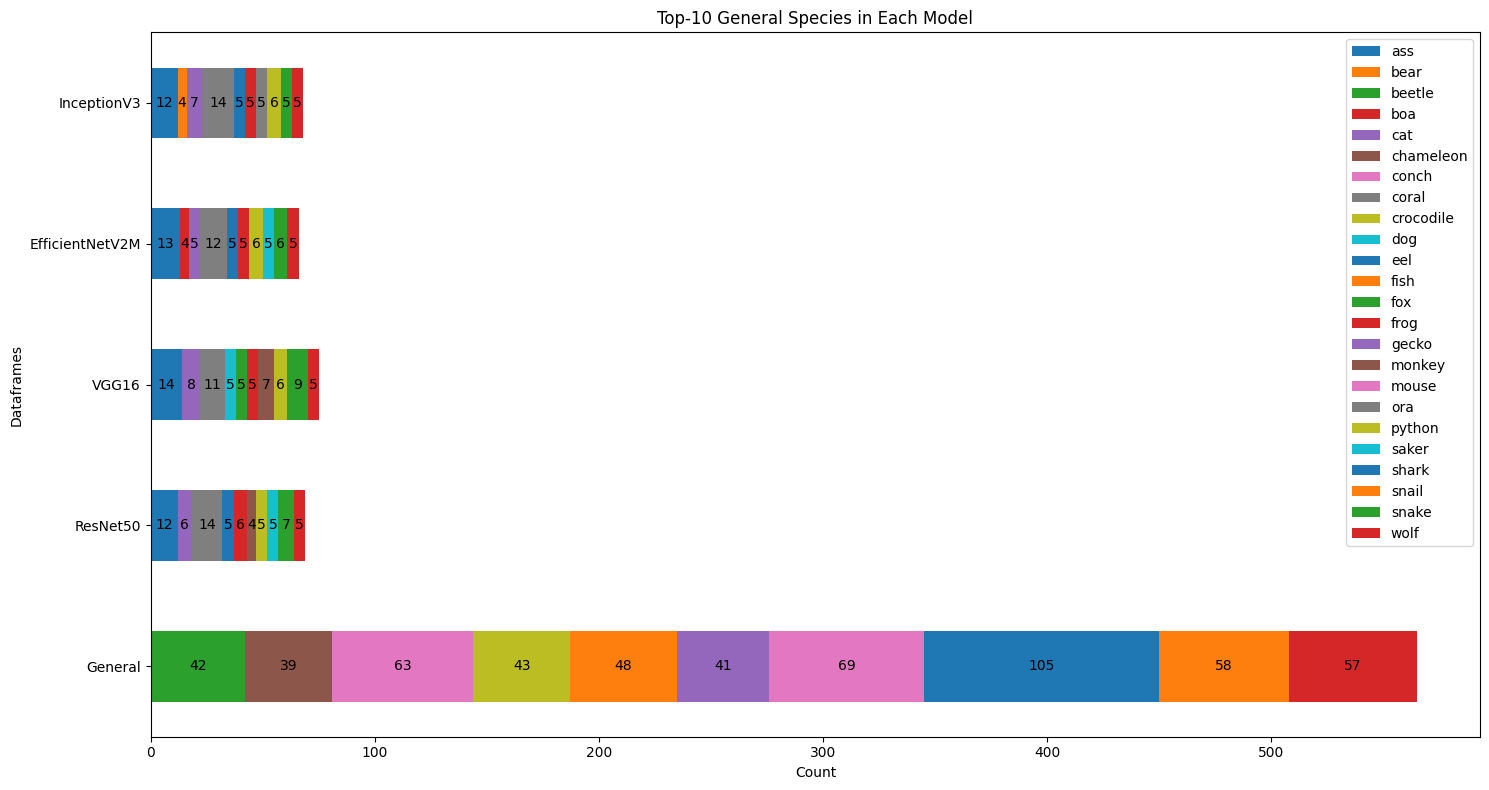

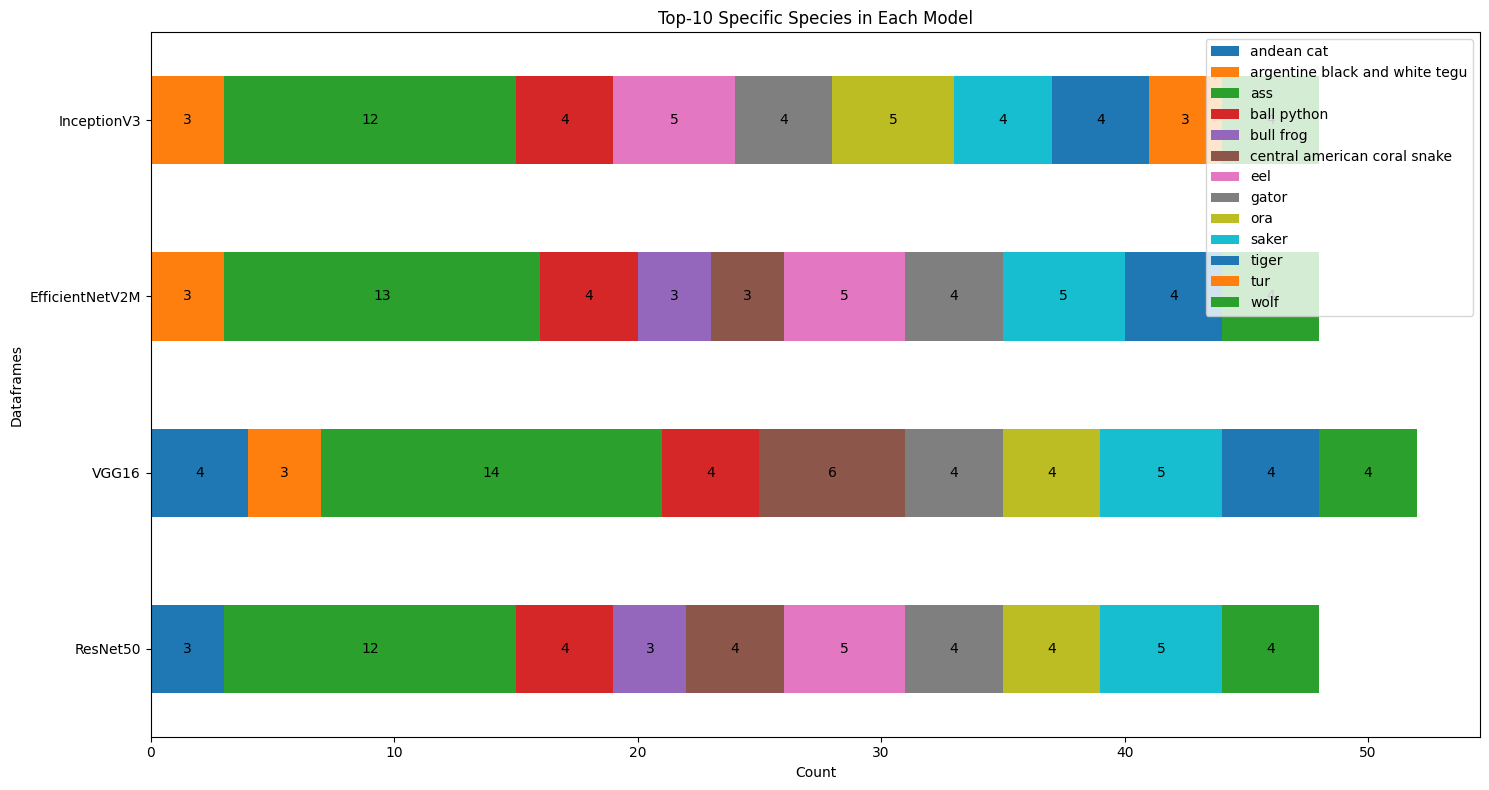

In [102]:
def plot_top10_species(data, title):
    ax = data.plot(kind='barh', stacked=True, figsize=(15, 8))

    plt.xlabel('Count')
    plt.ylabel('Dataframes')
    plt.title(title)

    plt.tight_layout()

    # Annotate the count on the bars
    for p in ax.patches:
        width = p.get_width()  # Width of the bar (the count)
        if width > 0:  # Only label the bar if width is greater than 0
            plt.text(p.get_x() + width/2,
                     p.get_y() + p.get_height()/2,
                     f'{int(width)}',
                     ha='center',
                     va='center')

    plt.show()

general_data = general_data.T
specific_data = specific_data.T

plot_top10_species(general_data, 'Top-10 General Species in Each Model')
plot_top10_species(specific_data, 'Top-10 Specific Species in Each Model')